In [158]:
!pip install mplfinance
!pip install ta
!pip install torcheval
!pip install tqdm
!pip install skforecast

In [159]:
import os
import torch
import random
import warnings
import cvxopt as opt
import numpy as np
import pandas as pd
import seaborn as sns
import torch.nn as nn
import tensorflow as tf
import mplfinance as mpf
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as sch
from cvxopt import blas, solvers
from google.colab import drive
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
from torch import nn, optim
from torcheval.metrics import BinaryAUROC
from torchvision import datasets, transforms
from torch.utils.data import Subset, TensorDataset, DataLoader, random_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler

In [160]:
# PARA GARANTIZAR REPRODUCIBILIDAD EN LOS RESULTADOS
random_state = 42
batch_size = 16
torch.manual_seed(42)
tf.random.set_seed(42)
torch.cuda.manual_seed_all(42)
np.random.seed(42)
random.seed(42)

# **Ejercicio 1:** Exploración de los Datos

In [161]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [162]:
# Directorio donde se encuentran los archivos CSV
directorio = '/content/drive/MyDrive/IA en Finanzas/datosSAN2018/tick_san/'

# Lista para almacenar los DataFrames de cada archivo CSV
dfs = []

# Iterar sobre cada archivo en el directorio
for archivo in os.listdir(directorio):
    if archivo.endswith('.csv'):
        df = pd.read_csv(os.path.join(directorio, archivo), parse_dates = True, index_col=0)
        dfs.append(df)

datos_san_2018 = pd.concat(dfs)

In [163]:
datos_san_2018

,VOLUMEN,PRECIO
TIME,,
2018-02-19 09:00:29,30,5.6340
2018-02-19 09:00:29,10,5.6340
2018-02-19 09:00:29,75,5.6340
2018-02-19 09:00:29,25,5.6340
2018-02-19 09:00:29,6,5.6340
...,...,...
2018-11-12 17:35:13,20771,4.1965
2018-11-12 17:35:13,21047,4.1965
2018-11-12 17:35:13,2262,4.1965


In [164]:
# Calculamos las velas diarias mediante el método ohlc (opeh-high-low-close) y eliminamos los NaNs
df_velas_diarias = datos_san_2018['PRECIO'].resample('D').ohlc().dropna()
# Agregamos el volumen de forma diaria
df_velas_diarias['volume'] = datos_san_2018['VOLUMEN'].resample('D').sum()

In [165]:
df_velas_diarias

,open,high,low,close,volume
TIME,,,,,
2018-01-02,5.5270,5.5400,5.4350,5.4540,34104335
2018-01-03,5.4800,5.4800,5.4220,5.4550,33113605
2018-01-04,5.4800,5.6440,5.4740,5.6380,52842463
2018-01-05,5.6600,5.7290,5.6340,5.6750,39946693
2018-01-08,5.6940,5.7340,5.6650,5.6920,30370694
...,...,...,...,...,...
2018-12-21,3.9600,3.9955,3.8815,3.9305,94601637
2018-12-24,3.9000,3.9275,3.8745,3.8915,11250288
2018-12-27,3.9575,3.9600,3.8000,3.8620,49647595


In [166]:
# Lo mismo que para velas diarias, pero en este caso la agregación se realiza por meses ('M') en vez de días ('D')
df_velas_mensuales = datos_san_2018['PRECIO'].resample('M').ohlc().dropna()
df_velas_mensuales['volume'] = datos_san_2018['VOLUMEN'].resample('M').sum()

In [167]:
df_velas_mensuales

,open,high,low,close,volume
TIME,,,,,
2018-01-31,5.5270,6.0930,5.4220,5.9830,810240858
2018-02-28,6.0600,6.0630,5.4060,5.6670,900102102
2018-03-31,5.6400,5.6460,5.1350,5.2950,839201589
2018-04-30,5.2600,5.5740,5.1050,5.3730,633560681
2018-05-31,5.3590,5.5370,4.5385,4.6000,1025401578
2018-06-30,4.6840,4.8965,4.5000,4.5920,942470496
2018-07-31,4.5320,4.8580,4.4535,4.8195,705191399
2018-08-31,4.8260,4.8420,4.2555,4.2880,705277938
2018-09-30,4.2875,4.6360,4.1400,4.3355,773551137


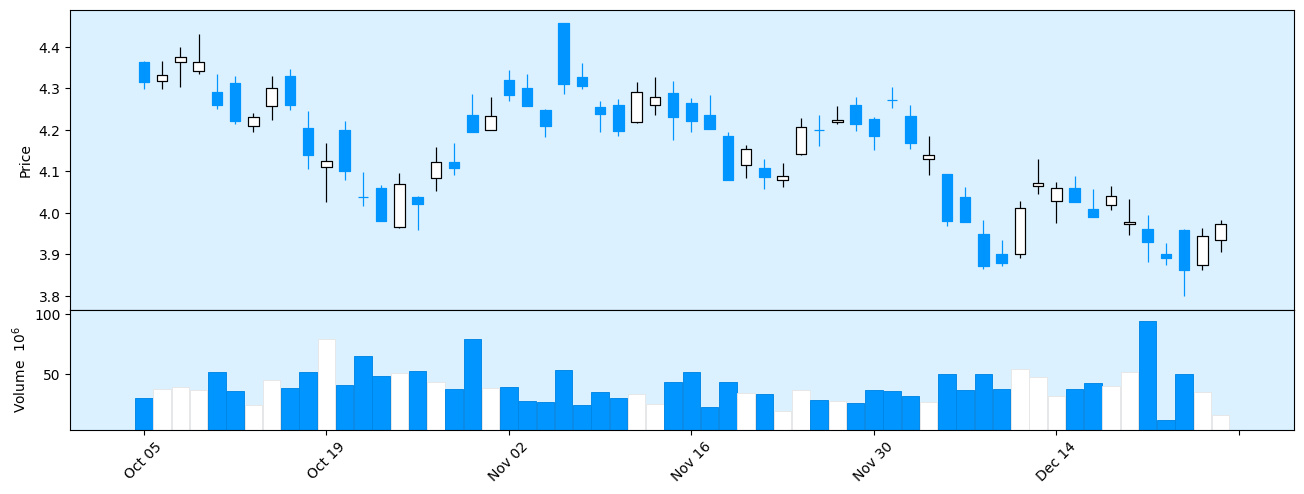

In [168]:
# GRÁFICO DE VELAS DIARIO
mpf.plot(df_velas_diarias.iloc[-60:],type='candle', style = 'blueskies', volume=True, figsize=(17,6))

Como se puede observar en el gráfico anterior, las velas aportan información sobre el high/close y el rango de precios sobre el que ha fluctuado la acción ese día en concreto.

En este caso, si el preio de cierre (close) es mayor que el precio de apertura (open), las velas aparecen en un color blanco (representando un día alcista). Por el contrario, si el precio de apertura es más alto que el de cierre, las velas se pintan de color azul, indicando un día bajista. La longitud de la vela viene determinado por la diferencia entre los valores de open y close.

Por otro lado, las mechas de las velas representan el rango entre el precio máximo y mínimo (siendo la parte superior de la mecha el valor máximo y el inferior el mínimo).
La longitud de las mechas representan la diferencia entre el precio máximo y mínimo alcanzado en el día. Por otro lado, la longitud de las velas.


El histograma de volumen que se genera justo debajo del de velas permite representar en forma de barras el volumen de acciones negociado cada día. Del mismo modo que ocurre arriba, las barras se pintan de azul en días bajistaqs y de blanco en alcistas (se puede observar cómo el color de las velas y las barras coinciden para un día en concreto).

Como observación general, es posible determinar que la tendencia a lo largo de los dos meses mostrados es decreciente, siendo más común la presencia de días bajistas que alcistas (y habiendo mayor diferencia entre el open y close que en los alcistas).


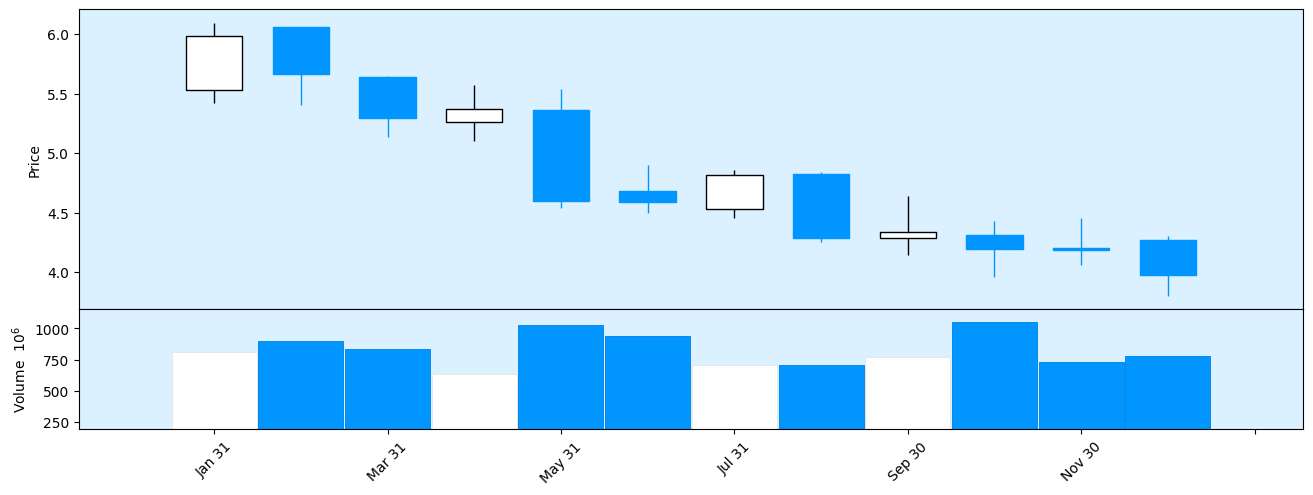

In [169]:
# GRÁFICO DE VELAS MENSUALES
mpf.plot(df_velas_mensuales,type='candle', style = 'blueskies', volume=True, figsize=(17,6))

Dado que en el gráfico anterior ya se mencionó la semántica asociada a los gráficos de velas y el histograma de volumen, en este caso únicamente se extraerán conclusiones sobre los resultados obtenidos.

Al igual que en el gráfico diario, en este caso también existe una clara tendencia bajista a lo largo de los meses (pudiendo ser un posible indicador de una recesión, aunque deberían tomarse en cuenta más factores para afirmar esto). En cuanto al gráfico de barras, es fácil observar que, al representar los volúmenes agrupados mensualmente, no existen picos tan pronunciados como si se presentaran de forma diaria. En este caso, el histograma mensual es más uniforme que el diario.

In [170]:
# Seleccionamos un día aleatorio de la lista original que contiene todos los DataFrames (en este caso, el que tiene el índice 0)
dia_df = dfs[0]
dia_df

,VOLUMEN,PRECIO
TIME,,
2018-02-19 09:00:29,30,5.634
2018-02-19 09:00:29,10,5.634
2018-02-19 09:00:29,75,5.634
2018-02-19 09:00:29,25,5.634
2018-02-19 09:00:29,6,5.634
...,...,...
2018-02-19 17:35:23,22430,5.587
2018-02-19 17:35:23,10867,5.587
2018-02-19 17:35:23,3428,5.587


In [171]:
# Calculamos el peso en cada instante de tiempo
dia_df['PxV'] = dia_df['PRECIO'] * dia_df['VOLUMEN']
dia_df['VWAP'] = dia_df['PxV'].expanding().sum()/dia_df['VOLUMEN'].expanding().sum()

dia_df

,VOLUMEN,PRECIO,PxV,VWAP
TIME,,,,
2018-02-19 09:00:29,30,5.634,169.020,5.634000
2018-02-19 09:00:29,10,5.634,56.340,5.634000
2018-02-19 09:00:29,75,5.634,422.550,5.634000
2018-02-19 09:00:29,25,5.634,140.850,5.634000
2018-02-19 09:00:29,6,5.634,33.804,5.634000
...,...,...,...,...
2018-02-19 17:35:23,22430,5.587,125316.410,5.607909
2018-02-19 17:35:23,10867,5.587,60713.929,5.607901
2018-02-19 17:35:23,3428,5.587,19152.236,5.607898


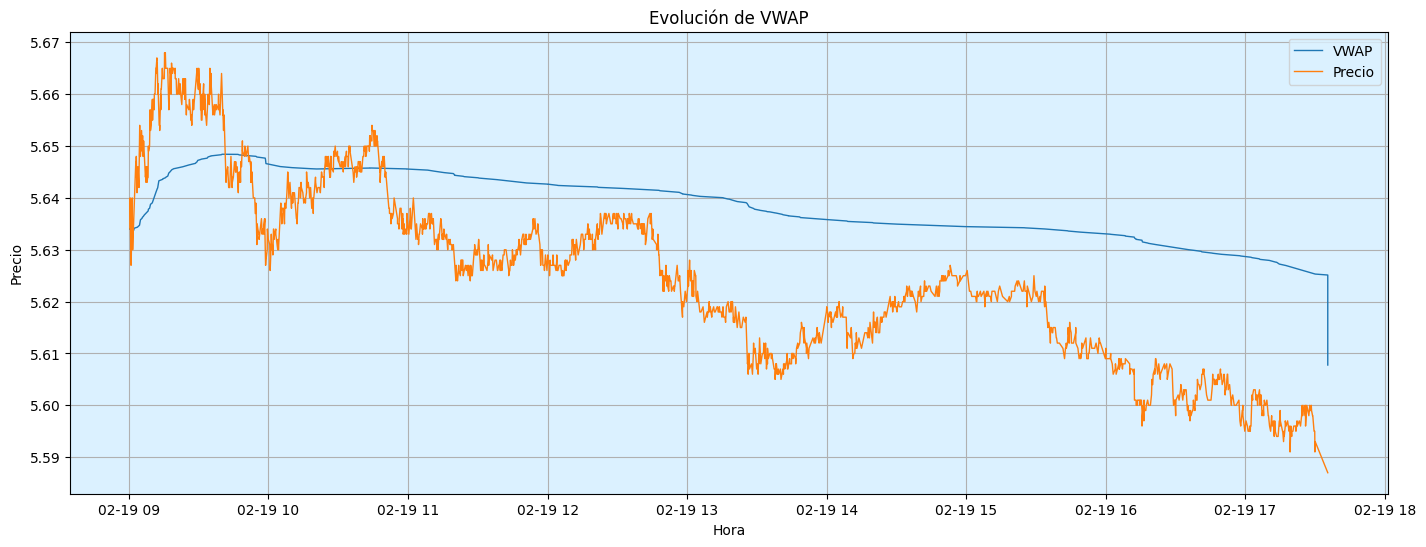

In [172]:
# Mostramos la evolución del precio y el VWAP en forma de gráfico para poder analizar mejor los resultados
plt.figure(figsize=(17, 6))
plt.ylabel('Precio')
plt.xlabel('Hora')
plt.title('Evolución de VWAP')
plt.grid(True)
plt.plot(dia_df['VWAP'], label='VWAP')
plt.plot(dia_df['PRECIO'], label='Precio')
plt.legend(loc='best')
plt.show()

En el gráfico anterior se puede observar la evolución del VWAP y el precio de las acciones a lo largo del día.
Aunque presente fluctuaciones, la tendencia general del precio es decreciente. Esto puede ser un indicador de que, en este día, había una presión de venta consistente o que había falta de interés de los compradores. De este modo, el precio de las acciones va bajando.

Por otro lado, el VWAP (Volumen Ponderado por Precio) al ser una medida que representa el precio promedio ponderado por el volumen de negociación, está íntimamente relacionado con el precio de las acciones:

$$ VWAP = \frac{\sum_{i=1}^{n} (P_i \times V_i)}{\sum_{i=1}^{n} V_i} $$

 Debido a esto, como se puede observar, este cálculo también tiene una tendencia general decreciente. En los últimos momentos del día (teniendo en cuenta que el mercado cierra en torno a las 17:35), el volumen de venta se dispara, el VWAP se reduce unos cuantos puntos, alcanzando valores de entorno a 5.60.

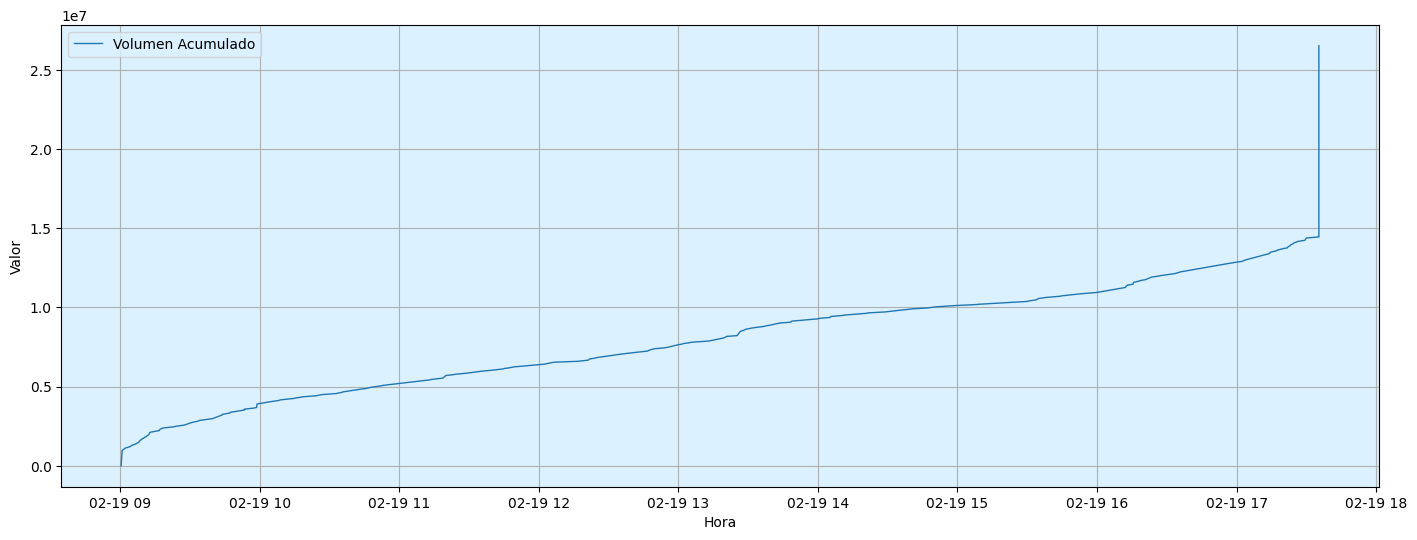

In [173]:
# Mostramos la evolución del volumen acumulado en forma de gráfico para poder analizarlo más fácilmente
plt.figure(figsize=(17, 6))
plt.xlabel('Hora')
plt.ylabel('Valor')
plt.grid(True)
plt.plot(dia_df['VOLUMEN'].expanding().sum(), label='Volumen Acumulado')
plt.legend(loc='best')
plt.show()

En cuanto a la evolución del volumen acumulado para este día en concreto, como se puede observar, por supuesto, la evolución es creciente a lo largo de las horas (dado que es un cálculo acumulado). Además, el volumen de venta, como se puede observar, tiene un crecimiento bastante pronunciado al comienzo del dia, y mucho mayor al final del día. Estos resultados son coherentes teniendo en cuenta que la mayor parte de la actividad (y la mayoría del volumen negociado) se realiza al comienzo (open), y sobre todo, al final (close) del día.

# **Ejercicio 2:** Cálculo y Estimación de Volumen Diario

In [174]:
# Generamos un nuevo dataframe sobre el que se normalizarán los volúmenes en intervalos de 30 minutos
volumen_normalizado = pd.DataFrame()

In [175]:
# Generamos otros dataframes auxiliares que nos serán de utilidad para obtener el volumen normalizado
volumen_media_hora_df = pd.DataFrame()
volumen_diario_df = pd.DataFrame()

volumen_media_hora_df['VOLUMEN'] = datos_san_2018['VOLUMEN'].resample('30T').sum()
volumen_diario_df['VOLUMEN'] = datos_san_2018['VOLUMEN'].resample('D').sum()

In [176]:
# Para calcular el volumen normalizado se dividen los valores de la serie agregados en tramos de 30 minutos entre el total diario
volumen_normalizado["VOLUMEN_NORMALIZADO"] = volumen_media_hora_df.div(volumen_diario_df.reindex(volumen_media_hora_df.index, method='ffill'))

In [177]:
volumen_normalizado

,VOLUMEN_NORMALIZADO
TIME,
2018-01-02 09:00:00,0.085968
2018-01-02 09:30:00,0.054624
2018-01-02 10:00:00,0.047574
2018-01-02 10:30:00,0.095950
2018-01-02 11:00:00,0.043250
...,...
2018-12-31 12:00:00,0.058166
2018-12-31 12:30:00,0.053470
2018-12-31 13:00:00,0.042591


In [178]:
# Eliminamos los posibles 0s que existan en el dataframe
volumen_normalizado = volumen_normalizado.loc[volumen_normalizado['VOLUMEN_NORMALIZADO'] != 0]

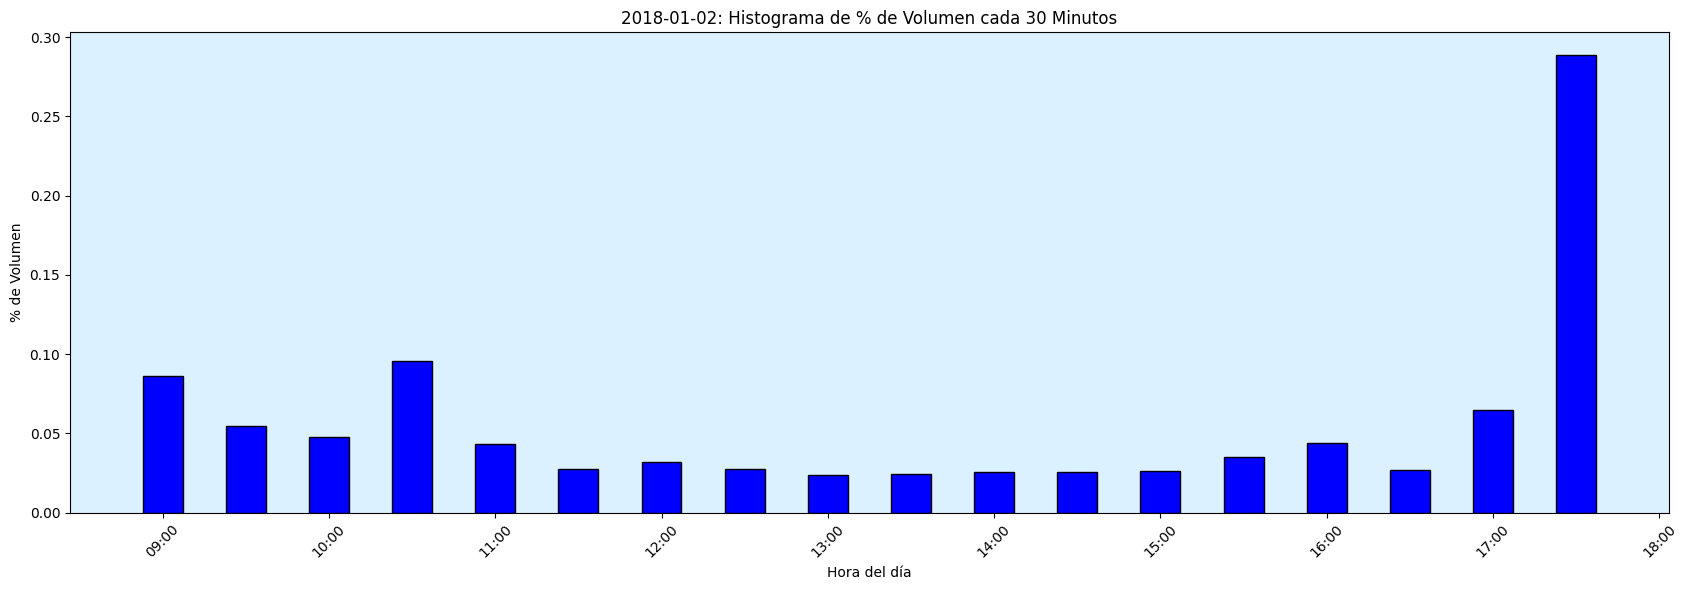

In [179]:
# Para la fecha aleatoria seleccionada (2018-01-02), mostramos el histograma de volumen normalizado en tramos de media hora
plt.figure(figsize=(17, 6))

fecha_elegida = "2018-01-02"

plt.bar(volumen_normalizado.loc[fecha_elegida].index, volumen_normalizado.loc[fecha_elegida]["VOLUMEN_NORMALIZADO"], width=0.01, color='blue')


plt.xticks(rotation=45)  # Rotamos las etiquetas para mejorar la legibilidad
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%H:%M'))


plt.xlabel('Hora del día')
plt.ylabel('% de Volumen')
plt.title(f'{fecha_elegida}: Histograma de % de Volumen cada 30 Minutos')
plt.tight_layout()

plt.show()

Para este día en concreto, y de acuerdo a lo mencionado en las clases, la mayor parte de la actividad (y por tanto, del volumen negociado) ocurre en el cierre. En el histograma anterior es muy sencillo apreciar la diferencia entre el último tramo y el resto de intervalos en el día.
Existe también actividad relevante en la apertura y por la mañana (en torno a las 10:30).

### Valor medio diario por intervalos de 30 minutos de todo el año

In [180]:
# Para realizar este cálculo, agrupamos todas las entradas según su hora y minuto, de este modo, agregamos todos los valores de volumen para cada intervalo de media hora, y posteriormente calculamos la media
vol_medio_diario = volumen_normalizado.groupby([volumen_normalizado.index.hour, volumen_normalizado.index.minute]).mean()
# Eliminamos los NaN de la tabla (que han ocurrido para los valores en los que el valor agregado es 0 porque no hay actividad, como por ejemplo a las 00:30)
vol_medio_diario.dropna(subset=['VOLUMEN_NORMALIZADO'], inplace=True)
vol_medio_diario = vol_medio_diario.rename(columns={'VOLUMEN_NORMALIZADO': 'VOLUMEN_MEDIO'})

In [181]:
vol_medio_diario

VOLUMEN_MEDIO
TIME TIME               
9    0          0.079199
     30         0.044426
10   0          0.038398
     30         0.033720
11   0          0.031704
     30         0.042808
12   0          0.028495
     30         0.025622
13   0          0.024451
     30         0.024901
14   0          0.026357
     30         0.027317
15   0          0.025240
     30         0.037893
16   0          0.041217
     30         0.043383
17   0          0.057319
     30         0.372292

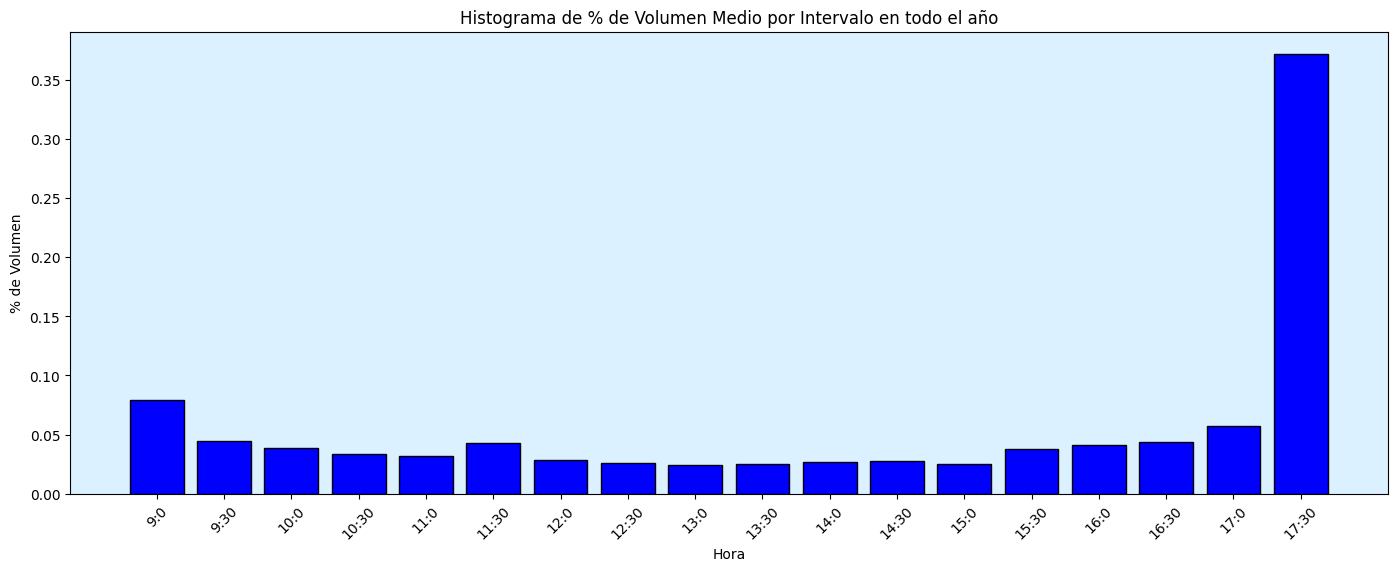

In [182]:
time_index = [f"{hour}:{minute}" for hour, minute in vol_medio_diario.index]
plt.figure(figsize=(17, 6))
plt.bar(time_index, vol_medio_diario["VOLUMEN_MEDIO"], color='blue')
plt.xticks(rotation=45)  # Rotar las etiquetas para mejorar la legibilidad
plt.xlabel('Hora')
plt.ylabel('% de Volumen')
plt.title('Histograma de % de Volumen Medio por Intervalo en todo el año')
plt.show()

De forma más genérica que en el apartado anterior, en este histograma se muestra la media del porcentaje de volumen que se negocia para cada intervalo de media hora durante todo el año. Al igual que ocurría en el día que se analizó previamente, y de acuerdo a lo que se explicó en clase, los resultados parecen bastante coherentes.

La inmensa mayoría de la actividad se condensa en el cierre. Una de las razones podría ser que los inversores prefieren tomar partido en el mercado cuando ya se tiene información sobre la actividad y los precios que han habido a lo largo del día. Además, como la mayoría de los inversores actúan en cierre, existe una mayor liquidez en el mercado, de la cual podrían aprovecharse.

## Modelos de Regresión

In [250]:
# Como base para los modelos de regresión se calcula, para cada día, la media de entre todos los volúmenes negociados, agrupándolos en intervalos de media hora
# Se realizará la regresión sobre el volumen normalizado, pero se añaden estas columnas únicamente por si luego se quieren derivar de ellas variables exógenas que puedan mejorar el desempeño de los modelos
df_volumen = datos_san_2018.resample("30T").mean()
df_volumen

,VOLUMEN,PRECIO
TIME,,
2018-01-02 09:00:00,1655.486731,5.521117
2018-01-02 09:30:00,1908.723361,5.514387
2018-01-02 10:00:00,1555.576222,5.491653
2018-01-02 10:30:00,1790.103392,5.466445
2018-01-02 11:00:00,1065.753613,5.446418
...,...,...
2018-12-31 12:00:00,1182.981481,3.970144
2018-12-31 12:30:00,1055.364570,3.963429
2018-12-31 13:00:00,1098.771812,3.961191


In [251]:
# Añadimos la columna de volumen normalizado
df_volumen['VOLUMEN_NORMALIZADO'] = volumen_normalizado["VOLUMEN_NORMALIZADO"]
# Se añaden columnas auxiliares para calcular el VWAP (posible variable exógena)
df_volumen['PxV'] = df_volumen['PRECIO'] * df_volumen['VOLUMEN']
df_volumen['VWAP'] = df_volumen['PxV'].expanding().sum()/df_volumen['VOLUMEN'].expanding().sum()
# Normalización dividiendo por el máximo de la columna 'VWAP' (mejorará el rendimiento de los modelos en la regresión)
max_vwap = df_volumen['VWAP'].max()
df_volumen['VWAP'] = df_volumen['VWAP'] / max_vwap

In [252]:
df_volumen

,VOLUMEN,PRECIO,VOLUMEN_NORMALIZADO,PxV,VWAP
TIME,,,,,
2018-01-02 09:00:00,1655.486731,5.521117,0.085968,9140.135738,0.942042
2018-01-02 09:30:00,1908.723361,5.514387,0.054624,10525.439850,0.941427
2018-01-02 10:00:00,1555.576222,5.491653,0.047574,8542.684711,0.940087
2018-01-02 10:30:00,1790.103392,5.466445,0.095950,9785.501284,0.938177
2018-01-02 11:00:00,1065.753613,5.446418,0.043250,5804.540036,0.936990
...,...,...,...,...,...
2018-12-31 12:00:00,1182.981481,3.970144,0.058166,4696.606261,0.824250
2018-12-31 12:30:00,1055.364570,3.963429,0.053470,4182.862961,0.824240
2018-12-31 13:00:00,1098.771812,3.961191,0.042591,4352.445315,0.824229


In [253]:
# NOTE: Realizamos cálculos para otra posible variable exógena, la diferencia entre el precio actual de la acción en función de la media diaria del día anterior
# Se mantienen los signos para ver si el modelo extrae conocimiento de ello (negativo es que el precio actual está por debajo de la media y positivo por encima)

# Se calcula la media del precio de venta para cada día
average_day_price = df_volumen.resample('D').mean().shift(1)

# Se calcula la diferencia del precio frente a la media diaria
for day in df_volumen.index:
    day = day.strftime('%Y-%m-%d')
    average_price = average_day_price.loc[day,'PRECIO']
    df_volumen.loc[day, 'DIFERENCIA_MEDIA'] = df_volumen.loc[day, 'PRECIO'] - average_price

In [254]:
# Se realiza una limpieza en el dataframe por si al generar las nuevas features se ha generado algún valor no deseado
df_volumen.replace(0, pd.NaT, inplace=True)
df_volumen = df_volumen.dropna()

In [255]:
df_volumen

,VOLUMEN,PRECIO,VOLUMEN_NORMALIZADO,PxV,VWAP,DIFERENCIA_MEDIA
TIME,,,,,,
2018-01-03 09:00:00,2036.155922,5.458737,0.082028,11114.839428,0.932032,-0.011494
2018-01-03 09:30:00,1382.017807,5.457163,0.044532,7541.896544,0.932012,-0.013068
2018-01-03 10:00:00,1495.618480,5.457809,0.030307,8162.800359,0.931994,-0.012422
2018-01-03 10:30:00,1402.094701,5.451643,0.037557,7643.719224,0.931956,-0.018588
2018-01-03 11:00:00,1347.870773,5.459295,0.033703,7358.423748,0.931946,-0.010936
...,...,...,...,...,...,...
2018-12-28 15:30:00,1345.756705,3.952136,0.040220,5318.613542,0.824629,0.067838
2018-12-28 16:00:00,1277.909605,3.948870,0.038851,5046.298972,0.824616,0.064572
2018-12-28 16:30:00,1236.996028,3.942768,0.035659,4877.187893,0.824604,0.058470


In [256]:
# Generamos una nueva variable exógena (volumen acumulado del día anterior)
# Para ello es necesario realizar una serie de pasos como agrupar por día, shiftear los datos y eliminar los NaN, que en este caso serán los del primer día (ya que no hay día anterior)
df_volumen['FECHA'] = df_volumen.index.date

# Desplazamos en 1 para obtener el valor del día anterior
df_volumen['VOLUMEN_ACUMULADO_ANTERIOR'] = df_volumen.groupby('FECHA')['VOLUMEN'].shift(1)
df_volumen['VOLUMEN_ACUMULADO_ANTERIOR'] = df_volumen['VOLUMEN_ACUMULADO_ANTERIOR'] / df_volumen['VOLUMEN_ACUMULADO_ANTERIOR'].max()

# Desplazamos en 1 para obtener el valor del día anterior
df_volumen['VWAP'] = df_volumen.groupby('FECHA')['VWAP'].shift(1)
df_volumen['VWAP'] = df_volumen['VWAP'] / df_volumen['VWAP'].max()

df_volumen.drop(columns=['FECHA'], inplace=True)
df_volumen.dropna(inplace=True)
df_volumen

,VOLUMEN,PRECIO,VOLUMEN_NORMALIZADO,PxV,VWAP,DIFERENCIA_MEDIA,VOLUMEN_ACUMULADO_ANTERIOR
TIME,,,,,,,
2018-01-03 09:30:00,1382.017807,5.457163,0.044532,7541.896544,0.932032,-0.013068,0.251957
2018-01-03 10:00:00,1495.618480,5.457809,0.030307,8162.800359,0.932012,-0.012422,0.171013
2018-01-03 10:30:00,1402.094701,5.451643,0.037557,7643.719224,0.931994,-0.018588,0.185070
2018-01-03 11:00:00,1347.870773,5.459295,0.033703,7358.423748,0.931956,-0.010936,0.173497
2018-01-03 11:30:00,1721.600890,5.460690,0.035042,9401.128612,0.931946,-0.009541,0.166788
...,...,...,...,...,...,...,...
2018-12-28 15:30:00,1345.756705,3.952136,0.040220,5318.613542,0.824642,0.067838,0.160268
2018-12-28 16:00:00,1277.909605,3.948870,0.038851,5046.298972,0.824629,0.064572,0.166526
2018-12-28 16:30:00,1236.996028,3.942768,0.035659,4877.187893,0.824616,0.058470,0.158130


In [257]:
# Esta función es esencial para generar las secuencias con las que se entrenarán los modelos de regresión
# Se genera una secuencia de valores de entrenamiento (X) y otra de etiquetas (Y) que serán de gran utilidad en el entrenamiento de modelos
# El parámetro 'exog' se utiliza para añadir a X la variable exógena de tal manera que las instancias de entrenamiento tienen el formato: (Xi, Exogi)
# Esta forma de añadir variables exógenas intercalándolas entre los valores de la serie es una de las muchas posibles maneras de incorporar variables exógenas con el fin de mejorar el rendimiento del modelo

def generate_dataset(data, window_size, exog=None):
    X, y = [], []

    for i in range(len(data) - window_size):
        # Se va formando el conjunto de train incorporando los valores de la serie
        sequence = data.iloc[i:i + window_size]["VOLUMEN_NORMALIZADO"].tolist()

        if exog is not None:
            # Si se ha incorporado una variable exógena, se intercala
            sequence += data.iloc[i:window_size+i][exog].tolist()

        X.append(sequence)
        y.append(data.iloc[window_size + i]["VOLUMEN_NORMALIZADO"])
    return torch.tensor(X), torch.tensor(y)

In [258]:
# Creamos esta clase para más adelante (será de utilidad para monitorizar el entrenamiento de los modelos e interrumpirlo cuando sea necesario)

class EarlyStopping:
    def __init__(self, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf

    def __call__(self, val_loss):
        if self.best_score is None:
            self.best_score = val_loss
        elif val_loss > self.best_score + self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = val_loss
            self.counter = 0

### **Creación de Datasets:** Sin variable exógena y con variable exógena

**Anotación:** Los modelos se entrenarán únicamente con conjunto de train (sin train+val) dado que las funciones de entrenamiento monitorizan el error de validación para interrumpir el entrenamiento y evitar el sobreajuste. De este modo, si se eliminara el conjunto de validación, no se podría evitar el sobreentrenamiento de los modelos.

In [259]:
window_size = 18 * 5  # 18 intervalos de media hora cada día * 5 días que se van a utilizar para predecir

In [260]:
# Sin variable exógena
X_volumen, y_volumen = generate_dataset(df_volumen, window_size)
# Se divide el conjunto en train y test (80% / 20%)
# Por supuesto, no se aplica shuffle ya que hay que mantener el orden secuencial (son series temporales)
X_train_volumen, X_test_volumen, y_train_volumen, y_test_volumen = train_test_split(X_volumen, y_volumen, test_size=0.2, shuffle=False)
# El conjunto de train se divide en train y val (al tomar un 25% del 80%, val acaba teniendo el mismo tamaño que test)
X_train_volumen, X_val_volumen, y_train_volumen, y_val_volumen = train_test_split(X_train_volumen, y_train_volumen, test_size=0.25, shuffle=False)

# A continuación se generan los datasets y loaders para poder alimentar a los modelos
train_dataset_volumen = TensorDataset(X_train_volumen, y_train_volumen)
train_loader_volumen = DataLoader(train_dataset_volumen, batch_size=64, shuffle=False)

val_dataset_volumen = TensorDataset(X_val_volumen, y_val_volumen)
val_loader_volumen = DataLoader(val_dataset_volumen, batch_size=64, shuffle=False)

test_dataset_volumen = TensorDataset(X_test_volumen, y_test_volumen)
test_loader_volumen = DataLoader(test_dataset_volumen, batch_size=64, shuffle=False)

**IMPORTANTE:** Es posible realizar pruebas con cualquiera de las variables exógenas que se mencionan a continuación (VWAP, DIFERENCIA_MEDIA, VOLUMEN_ACUMULADO_ANTERIOR). En este caso, únicamente se mostrarán los resultados con una de ellas (seleccionada aleatoriamente) para no alargar demasiado el código.

In [261]:
# Con variable exógena (puedes introducir cualquiera de las que especifico en la siguiente línea)
exog = 'VOLUMEN_ACUMULADO_ANTERIOR' # Otras posibles variables exógenas: 'VWAP' 'DIFERENCIA_MEDIA', 'VOLUMEN_ACUMULADO_ANTERIOR'
X_exog, y_exog = generate_dataset(df_volumen, window_size, exog)
# Se divide el conjunto en train y test (80% / 20%).
# Por supuesto, no se aplica shuffle ya que hay que mantener el orden secuencial (son series temporales)
X_train_exog, X_test_exog, y_train_exog, y_test_exog = train_test_split(X_exog, y_exog, test_size=0.2, shuffle=False)
# El conjunto de train se divide en train y val (al tomar un 25% del 80%, val acaba teniendo el mismo tamaño que test)
X_train_exog, X_val_exog, y_train_exog, y_val_exog = train_test_split(X_train_exog, y_train_exog, test_size=0.25, shuffle=False)

# A continuación se generan los datasets y loaders para poder alimentar a los modelos
train_dataset_exog = TensorDataset(X_train_exog, y_train_exog)
train_loader_exog = DataLoader(train_dataset_exog, batch_size=64, shuffle=False)

val_dataset_exog = TensorDataset(X_val_exog, y_val_exog)
val_loader_exog = DataLoader(val_dataset_exog, batch_size=64, shuffle=False)

test_dataset_exog = TensorDataset(X_test_exog, y_test_exog)
test_loader_exog = DataLoader(test_dataset_exog, batch_size=64, shuffle=False)

###  Perceptrón Multicapa

Por otro lado, se tiene al modelo que predice únicamente el volumen porcentual para el siguiente intervalo:

In [262]:
# AUTOREGRESIVO
# Montamos la arquitectura del MLP con MSE y EarlyStopping
class MLP(nn.Module):
    def __init__(self, dimx, num_labels, hidden_layers, dropout=None, batch_norm=False):
      super().__init__()

      self.num_hidden_layers = len(hidden_layers) + 1
      self.layers = [dimx] + hidden_layers + [num_labels]

      self.outputs = nn.ModuleList()
      for i in range(0, self.num_hidden_layers):
        self.outputs.append(nn.Linear(self.layers[i], self.layers[i+1]))

      self.relu = nn.ReLU()

      self.batch_norm = batch_norm
      self.batch_norm_layers = nn.ModuleList()
      if self.batch_norm:
        for b in range(0, self.num_hidden_layers):
          self.batch_norm_layers.append(nn.BatchNorm1d(self.layers[b + 1]))

      self.dropouts = nn.ModuleList()
      if dropout != None:
        for d in range(0, len(dropout)):
          self.dropouts.append(nn.Dropout(p=dropout[d]))

      self.sigmoid = nn.Sigmoid()

    def forward(self, x):

      start_dropout = None
      if len(self.dropouts) != 0:
        start_dropout = self.num_hidden_layers - 1 - len(self.dropouts)

      for l in range(0, self.num_hidden_layers - 1):
        x = self.outputs[l](x)
        if self.batch_norm:
          x = self.batch_norm_layers[l](x)
        x = self.relu(x)
        if start_dropout != None and l >= start_dropout:
          x = self.dropouts[l - start_dropout](x)

      x = self.outputs[-1](x)
      x = self.sigmoid(x)

      return x

In [263]:
# Extendemos la arquitectura de MLP anterior, incorporando el loop de entrenamiento (y validación) y un método para calcular el MSE
class MLP_extended(MLP):
    def __init__(self, hidden_layers, dimx=6000, num_labels=1, dropout=None, batch_norm=False, lr=0.001, n_epochs=20):

        super().__init__(dimx, num_labels, hidden_layers, dropout, batch_norm)
        self.lr = lr
        self.epochs = n_epochs
        self.optim = optim.Adam(self.parameters(), self.lr)

        self.criterion = F.mse_loss

        # LOSS EVOLUTION
        self.loss_during_training = []
        self.valid_loss_during_training = []

    def train_valid_loop(self, trainloader, valloader):

        earlyStopping = EarlyStopping(patience=10)
        for e in range(int(self.epochs)):
            running_loss = 0.
            for data, labels in trainloader:
                data = data.float()  # Convertir los datos a tipo float
                labels = labels.float()  # Convertir las etiquetas a tipo float
                self.optim.zero_grad()
                out = self.forward(data.view(data.shape[0], -1))
                loss = self.criterion(out.view(-1), labels)
                running_loss += loss.item()
                loss.backward()
                self.optim.step()

            self.loss_during_training.append(running_loss/len(trainloader))

            torch.save(self.state_dict(), f'model_weights_{e}.pth')

            with torch.no_grad():
                self.eval()
                val_run_loss = 0.
                for validdata, validlabels in valloader:
                    validout = self.forward(validdata.view(validdata.shape[0], -1))
                    validloss = self.criterion(validout.view(-1), validlabels)
                    val_run_loss += validloss.item()

                self.valid_loss_during_training.append(val_run_loss/len(valloader))
                earlyStopping(self.valid_loss_during_training[-1])

            self.train()

            if e % 1 == 0:
                print("training loss after %d epochs: %f" %(e, self.loss_during_training[-1]))
                print("validation loss after %d epochs: %f\n" %(e, self.valid_loss_during_training[-1]))

            if earlyStopping.early_stop:
                self.load_state_dict(torch.load(f'model_weights_{e - 10}.pth'))
                print('Stopping training due to early stopping')
                break

    def calculate_mse(self, testloader):
        criterion = nn.MSELoss()  # Criterio de pérdida de MSE
        total_loss = 0.0
        num_samples = 0

        self.eval()  # Poner el modelo en modo de evaluación

        with torch.no_grad():
            for data, labels in testloader:
                data = data.float()  # Convertir los datos a tipo float si es necesario
                labels = labels.float()  # Convertir las etiquetas a tipo float si es necesario

                # Realizar la inferencia con el modelo
                output = self(data.view(data.shape[0], -1))

                # Calcular la pérdida de MSE entre las predicciones y las etiquetas verdaderas
                loss = criterion(output.view(-1), labels)

                # Acumular la pérdida total y el número total de muestras
                total_loss += loss.item() * data.size(0)
                num_samples += data.size(0)

        # Calcular el MSE promedio dividiendo la pérdida total entre el número total de muestras
        mse = total_loss / num_samples
        return mse


### Sin variable exógena

In [264]:
# Definimos los parámetros que presentará el MLP
hidden_layers = [32,32,32]
epochs = 100
dropout = [0.25]
batch_norm = True
lr = 0.001

In [265]:
# Instanciamos el MLP, lo entrenamos y evaluamos su error (MSE) en el conjunto de test
# En este caso, sin variable exógena (por lo que utilizamos los datasets sin exógena: 'train_loader_volumen', etc...)
multi_layer = MLP_extended(hidden_layers, n_epochs=epochs, lr=lr, dropout = dropout, batch_norm = batch_norm, dimx=X_train_volumen.shape[1])
multi_layer.train_valid_loop(train_loader_volumen, val_loader_volumen)
print("MSE en test:", multi_layer.calculate_mse(test_loader_volumen))

training loss after 0 epochs: 0.110830
validation loss after 0 epochs: 0.158381

training loss after 1 epochs: 0.048713
validation loss after 1 epochs: 0.032196

training loss after 2 epochs: 0.024161
validation loss after 2 epochs: 0.011921

training loss after 3 epochs: 0.014781
validation loss after 3 epochs: 0.007482

training loss after 4 epochs: 0.009583
validation loss after 4 epochs: 0.005039

training loss after 5 epochs: 0.007443
validation loss after 5 epochs: 0.003443

training loss after 6 epochs: 0.005694
validation loss after 6 epochs: 0.002501

training loss after 7 epochs: 0.004655
validation loss after 7 epochs: 0.001889

training loss after 8 epochs: 0.003599
validation loss after 8 epochs: 0.001482

training loss after 9 epochs: 0.002848
validation loss after 9 epochs: 0.001240

training loss after 10 epochs: 0.002533
validation loss after 10 epochs: 0.001079

training loss after 11 epochs: 0.002743
validation loss after 11 epochs: 0.000992

training loss after 12 e

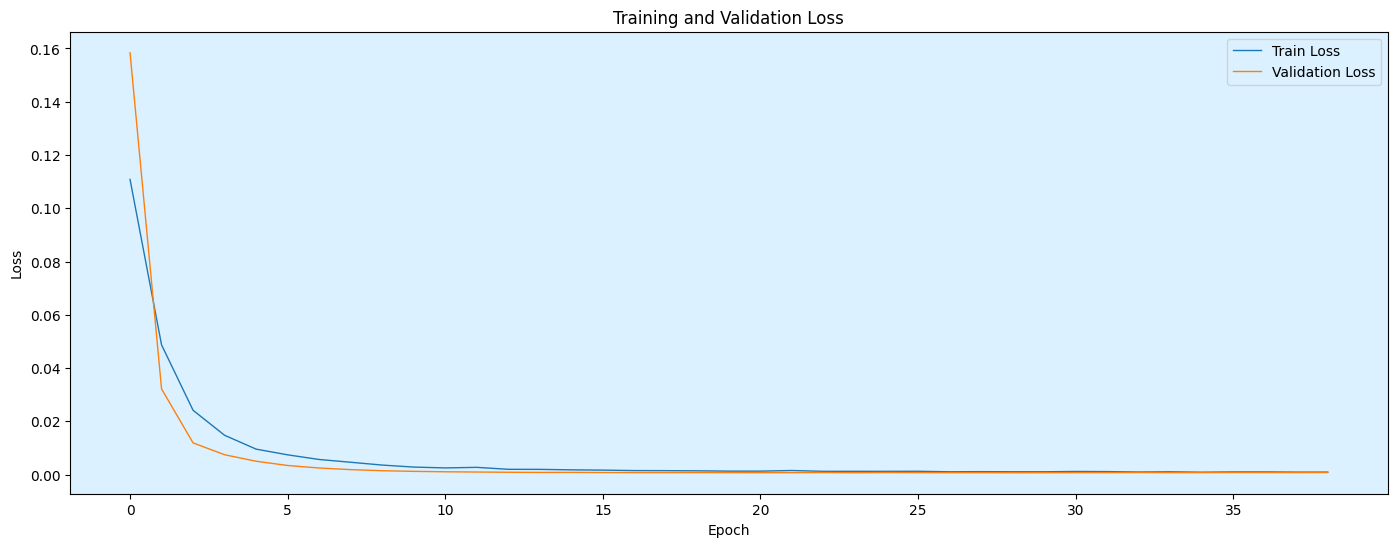

In [266]:
# Evolución del loss en train y validación
plt.figure(figsize=(17, 6))
plt.plot(multi_layer.loss_during_training, label='Train Loss')
plt.plot(multi_layer.valid_loss_during_training, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

Como se puede observar en la gráfica de evolución de loss, no existe sobreentrenamiento (el error de validación decrece y se mantiene cercano al de entrenamiento). Además, la curva se horizontaliza en las últimas épocas de entrenamiento, por lo que se puede asegurar que el modelo converge.

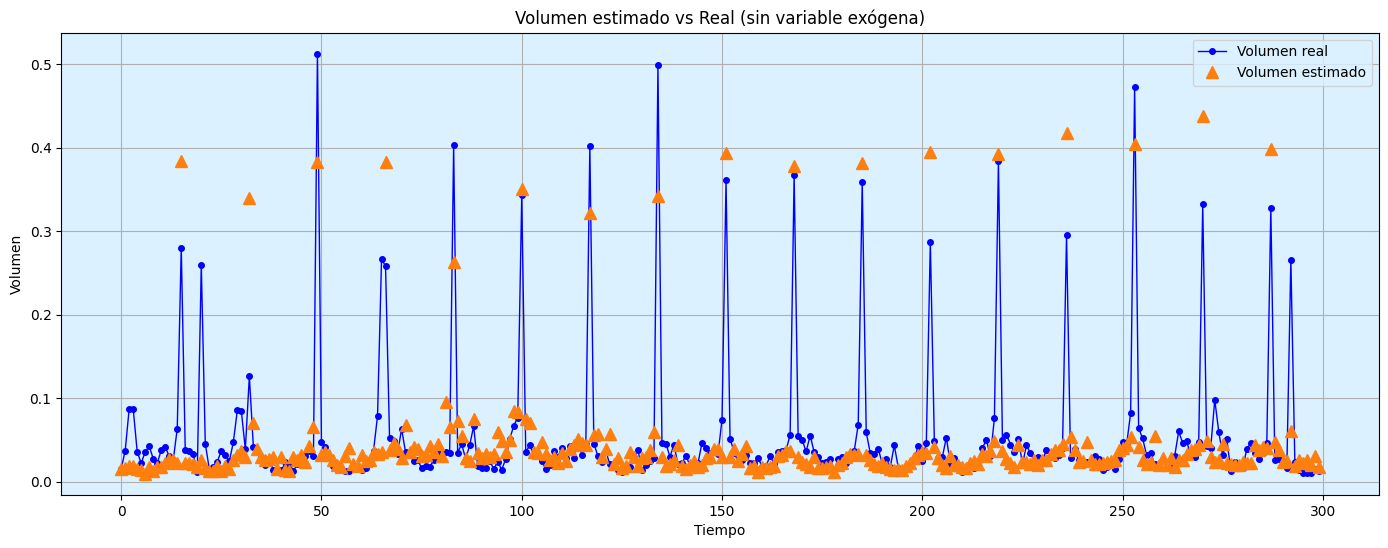

In [267]:
# Obtenemos las predicciones del modelo en el conjunto de pruebas
predictions = []
targets = []

with torch.no_grad():
    for data, labels in test_loader_volumen:
        data = data.float()
        labels = labels.float()
        output = multi_layer(data.view(data.shape[0], -1))
        predictions.extend(output.view(-1).numpy())
        targets.extend(labels.numpy())


plt.figure(figsize=(17, 6))

# Definir puntos de tiempo inicial y final para la representación (es configurable, para poder ver con mayor resolución y detalle los errores en una sección en concreto de todo el conjunto de test)

# Punto de tiempo inicial de la representación
t0 = 0

# Punto final
tf = 300

# Trazamos los valores reales y las predicciones
plt.plot(np.arange(t0, tf, 1), targets[t0:tf], 'b.-', label='Volumen real', markersize=8)
plt.errorbar(np.arange(t0, tf, 1), predictions[t0:tf], linestyle='None', marker='^', color='tab:orange', label='Volumen estimado', markersize=8, capsize=5)
plt.xlabel('Tiempo')
plt.ylabel('Volumen')
plt.title('Volumen estimado vs Real (sin variable exógena)')
plt.legend(loc='best')
plt.grid(True)

plt.show()

Como ya se ha indicado tras las trazas de loss en el entrenamiento del modelo, el MSE en el conjunto de test para este modelo es de 0.0009569656469625648.
Además, en el gráfico se puede ver que los errores son mucho menores que los que devuelve el modelo ONE-PASS para el siguiente intervalo. De este modo, **desde ahora todos los modelos generados seguirán esta idea, precidiendo únicamente el valor para el siguiente intervalo**. **Se proporcionará además una función para generar una predicción sobre todos los intervalos que conforman un día completo.**


En cuanto al gráfico, es fácil observar cómo el modelo es capaz de predecir con gran exactitud los intervalos en los que el volumen negociado es bajo. En los picos, sin embargo, el modeo mantiene de forma uniforme un cierto nivel que produce errores (ya que existen picos tanto por debajo como por encima). Sin embargo, el modelo sí que consigue detectar la tendencia en los ascensos y descensos de los picos de forma efectiva.

### Con variable exógena

In [268]:
# Instanciamos el MLP, lo entrenamos y evaluamos su MSE en test
# En este caso, con variable exógena (por lo que utilizamos los datasets con exógena: 'train_loader_exog', etc...)
multi_layer = MLP_extended(hidden_layers, n_epochs=epochs, lr=lr, dropout = dropout, batch_norm = batch_norm, dimx=X_train_exog.shape[1])
multi_layer.train_valid_loop(train_loader_exog, val_loader_exog)
print("MSE en test:", multi_layer.calculate_mse(test_loader_exog))

training loss after 0 epochs: 0.121733
validation loss after 0 epochs: 0.122593

training loss after 1 epochs: 0.056140
validation loss after 1 epochs: 0.047581

training loss after 2 epochs: 0.028404
validation loss after 2 epochs: 0.019595

training loss after 3 epochs: 0.016598
validation loss after 3 epochs: 0.011413

training loss after 4 epochs: 0.010814
validation loss after 4 epochs: 0.007138

training loss after 5 epochs: 0.007370
validation loss after 5 epochs: 0.004704

training loss after 6 epochs: 0.005411
validation loss after 6 epochs: 0.003336

training loss after 7 epochs: 0.004381
validation loss after 7 epochs: 0.002450

training loss after 8 epochs: 0.003410
validation loss after 8 epochs: 0.001933

training loss after 9 epochs: 0.002803
validation loss after 9 epochs: 0.001537

training loss after 10 epochs: 0.002358
validation loss after 10 epochs: 0.001300

training loss after 11 epochs: 0.002280
validation loss after 11 epochs: 0.001116

training loss after 12 e

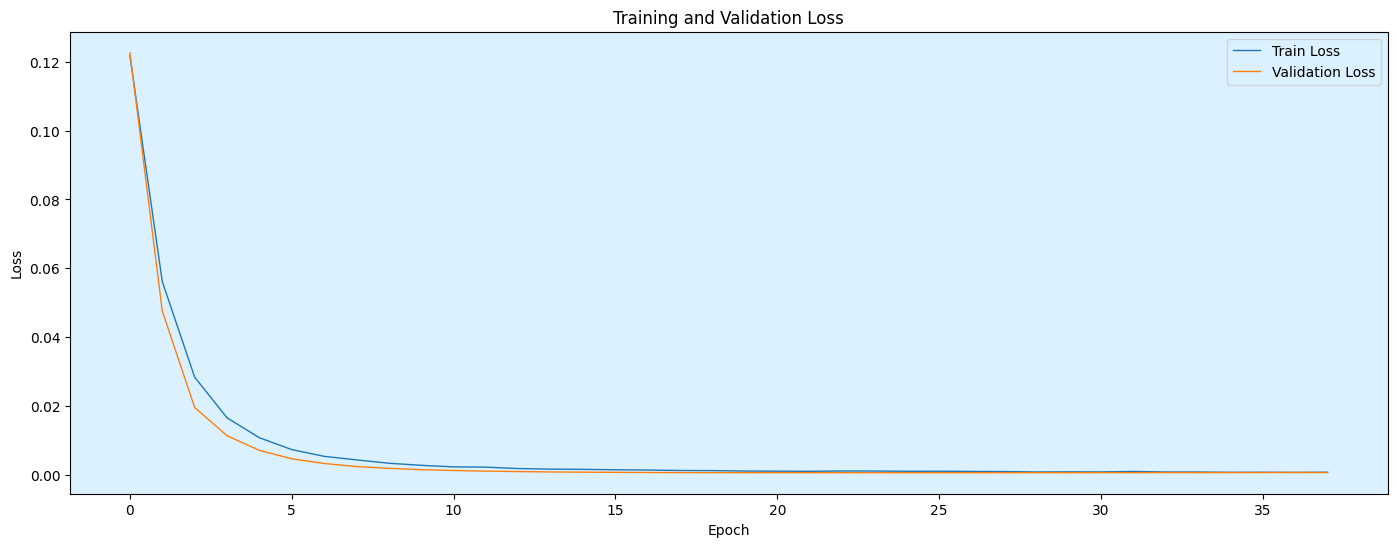

In [269]:
# Evolución del loss en train y validación
plt.figure(figsize=(17, 6))
plt.plot(multi_layer.loss_during_training, label='Train Loss')
plt.plot(multi_layer.valid_loss_during_training, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

Como se puede observar en la gráfica de evolución de loss, no existe sobreentrenamiento (el error de validación decrece y se mantiene cercano al de entrenamiento). Además, la curva se horizontaliza en las últimas épocas de entrenamiento, por lo que se puede asegurar que el modelo converge.

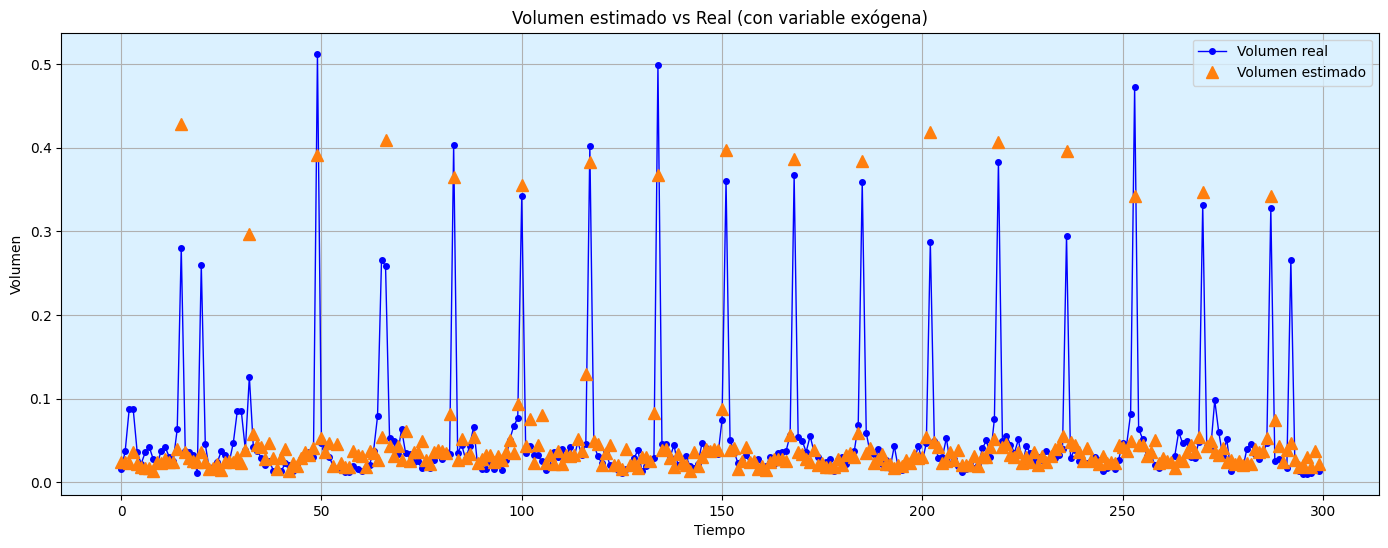

In [270]:
# Obtenemos las predicciones del modelo en el conjunto de pruebas
predictions = []
targets = []

with torch.no_grad():
    for data, labels in test_loader_exog:
        data = data.float()
        labels = labels.float()
        output = multi_layer(data.view(data.shape[0], -1))
        predictions.extend(output.view(-1).numpy())
        targets.extend(labels.numpy())


plt.figure(figsize=(17, 6))

# Definir puntos de tiempo inicial y final para la representación (es configurable, para poder ver con mayor resolución y detalle los errores en una sección en concreto de todo el conjunto de test)

# Punto de tiempo inicial de la representación
t0 = 0

# Punto final
tf = 300

# Trazamos los valores reales y las predicciones
plt.plot(np.arange(t0, tf, 1), targets[t0:tf], 'b.-', label='Volumen real', markersize=8)
plt.errorbar(np.arange(t0, tf, 1), predictions[t0:tf], linestyle='None', marker='^', color='tab:orange', label='Volumen estimado', markersize=8, capsize=5)
plt.xlabel('Tiempo')
plt.ylabel('Volumen')
plt.title('Volumen estimado vs Real (con variable exógena)')
plt.legend(loc='best')
plt.grid(True)

plt.show()

Como ya se ha indicado tras las trazas de loss en el entrenamiento del modelo, el MSE en el conjunto de test para este modelo es de 0.001106316436172162.
Al igual que ocurría en el modelo sin variable exógena, el modelo predice correctamente los intervalos de bajo volumen, pero, en este caso, tiende a sobreestimar (por lo general), los picos de alto volumen.
En general, el modelo también es capaz de detectar las tendencias.

### LSTM

In [271]:
# Generamos la arquitectura de LSTM, incorporando los métodos necesarios para su entrenamiento, monitorización del error (EarlyStopping) y evaluación del MSE
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_epochs, lr, num_layers=1):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.num_epoch = num_epochs
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)
        self.criterion = nn.MSELoss()
        self.optimizer = torch.optim.Adam(self.parameters(), lr=lr)
        self.loss_during_training = []
        self.valid_loss_during_training = []


    def forward(self, x, h0 = None):
        h_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        c_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        # Propagate input through LSTM
        out, (hn, cn) = self.lstm(x, (h_0, c_0))

        out = self.fc(out[:, -1, :])

        return out.squeeze()

    def trainloop(self, trainloader, valloader):
        early_stopping = EarlyStopping(patience=40, min_delta=0)
        for epoch in range(self.num_epoch):
            running_loss = 0.

            for inputs, targets in trainloader:
                inputs = torch.Tensor(inputs).view([inputs.shape[0], 1, input_size]).float()
                self.train()
                self.optimizer.zero_grad()
                outputs = self.forward(inputs)
                loss = self.criterion(outputs, targets.float())
                loss.backward()
                self.optimizer.step()
                running_loss += loss.item()

            torch.save(self.state_dict(), f'model_weights_{epoch}.pth')

            self.loss_during_training.append(running_loss / len(trainloader))

            with torch.no_grad():
                running_loss = 0.
                for inputs, targets in valloader:
                    inputs = torch.Tensor(inputs).view([inputs.shape[0], 1, input_size]).float()
                    y_val_pred = self.forward(inputs)
                    mse_val = self.criterion(y_val_pred, targets.float())
                    running_loss += mse_val.item()

                val_loss = running_loss / len(valloader)
                self.valid_loss_during_training.append(val_loss)

                early_stopping(val_loss)
                if early_stopping.early_stop:
                    self.load_state_dict(torch.load(f'model_weights_{epoch - 40}.pth'))
                    print('Stopping training due to early stopping')
                    break

            if (epoch + 1) % 10 == 0:
                print(f'Epoch [{epoch+1}/{self.num_epoch}], Train loss: {loss.item():.6f}, Val loss: {mse_val.item():.6f}')


    def evaluate_mse(self, testloader):
        mse_total = 0
        with torch.no_grad():
            for inputs,targets in testloader:
                inputs = torch.Tensor(inputs).view([inputs.shape[0],1,input_size]).float()
                y_test_pred = self.forward(inputs)
                mse_test = self.criterion(y_test_pred, targets.float())
                mse_total += mse_test

        return float(mse_total/len(testloader))

### Sin variable exógena

In [272]:
# Del mismo modo que en el MLP, definimos los parámetros de la LSTM

input_size = X_train_volumen.shape[1]
hidden_size = 64
num_layers = 1
learning_rate = 0.001
num_epochs = 80

# Instanciamos el modelo, lo entrenamos y evaluamos su MSE en test
# De nuevo, al ser el entrenamiento sin variable exógena, se tendrán que emplear los correspondientes datasets
lstm = LSTMModel(input_size, hidden_size, num_epochs, learning_rate, num_layers)
lstm.trainloop(train_loader_volumen, val_loader_volumen)
print("MSE en conjunto de test:", lstm.evaluate_mse(test_loader_volumen))

Epoch [10/80], Train loss: 0.000020, Val loss: 0.000369
Epoch [20/80], Train loss: 0.000026, Val loss: 0.000345
Epoch [30/80], Train loss: 0.000030, Val loss: 0.000324
Epoch [40/80], Train loss: 0.000032, Val loss: 0.000304
Epoch [50/80], Train loss: 0.000033, Val loss: 0.000285
Epoch [60/80], Train loss: 0.000034, Val loss: 0.000268
Epoch [70/80], Train loss: 0.000034, Val loss: 0.000254
Epoch [80/80], Train loss: 0.000034, Val loss: 0.000242
MSE en conjunto de test: 0.0010007283417508006


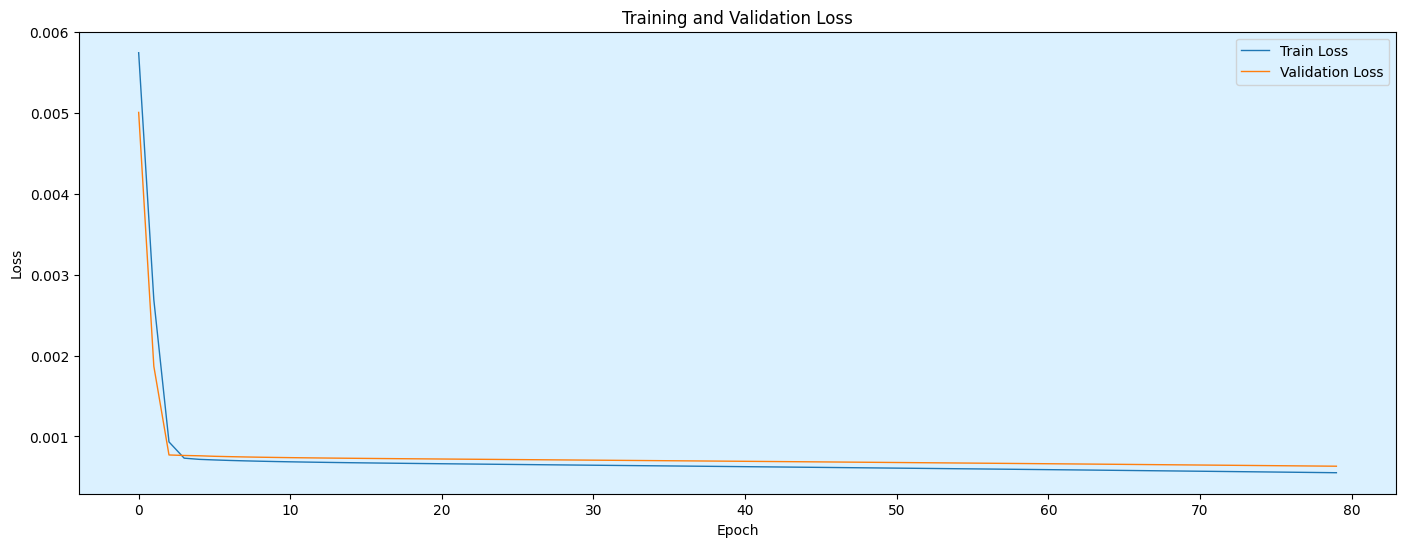

In [273]:
# Evolución del loss en train y validación
plt.figure(figsize=(17, 6))
plt.plot(lstm.loss_during_training, label='Train Loss')
plt.plot(lstm.valid_loss_during_training, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

Como se puede observar en la gráfica de evolución de loss, no existe sobreentrenamiento (el error de validación decrece y se mantiene cercano al de entrenamiento). Además, la curva se horizontaliza en las últimas épocas de entrenamiento, por lo que se puede asegurar que el modelo converge.

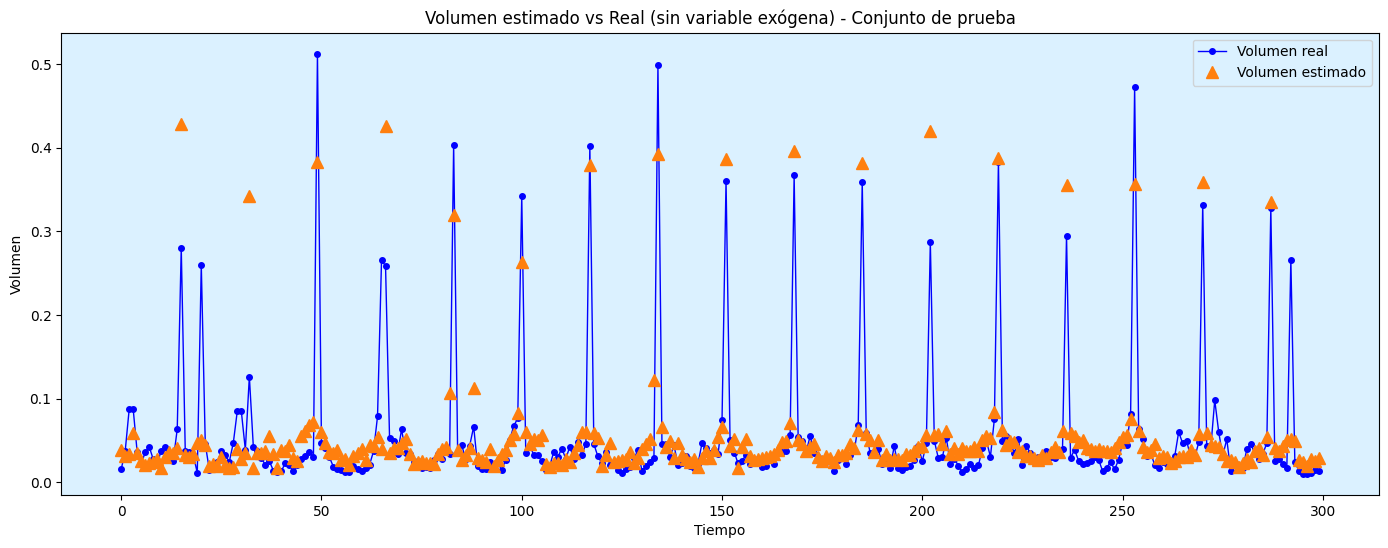

In [274]:
# Obtenemos predicciones en el conjunto de prueba
X_test_in = torch.Tensor(X_test_volumen).view([X_test_volumen.shape[0], 1, X_test_volumen.shape[1]]).float()
predictions_test = lstm.forward(X_test_in)
predictions_test = predictions_test.detach().numpy().reshape([X_test_volumen.shape[0], -1])

# Definir puntos de tiempo inicial y final para la representación (es configurable, para poder ver con mayor resolución y detalle los errores en una sección en concreto de todo el conjunto de test)

# Punto de tiempo inicial de la representación
t0 = 0

# Punto final
tf = 300

# Configuración del estilo del gráfico
plt.figure(figsize=(17, 6))

# Trazamos los valores reales y las predicciones
plt.plot(np.arange(t0, tf, 1), y_test_volumen[t0:tf], 'b.-', label='Volumen real', markersize=8)
plt.errorbar(np.arange(t0, tf, 1), predictions_test[t0:tf], linestyle='None', marker='^', color='tab:orange', label='Volumen estimado', markersize=8, capsize=5)
plt.xlabel('Tiempo')
plt.ylabel('Volumen')
plt.title('Volumen estimado vs Real (sin variable exógena) - Conjunto de prueba')
plt.legend(loc='best')

plt.show()

En este caso, para la LSTM sin variable exógena, el MSE en el conjunto de test para este modelo es de 0.0009859808487817645.
En este caso, el modelo (al igual que ocurría con los MLP) es capaz de predecir de forma precisa los intervalos de bajo volumen, pero tiende a sobreestimar (por lo general), los picos de alto volumen.
En general, el modelo también es capaz de detectar las tendencias.
Sin embargo, parece que el aplicar un modelo más complejo como puede ser una LSTM no genera ventajas frente a, por ejemplo, un MLP.

### Con variable exógena

In [275]:
# Del mismo modo que en el caso anterior, definimos los parámetros de la LSTM
input_size = X_train_exog.shape[1]
hidden_size = 64
num_layers = 1
learning_rate = 0.001
num_epochs = 60

# Instanciamos el modelo, lo entrenamos y evaluamos su MSE en test
# De nuevo, al ser el entrenamiento con variable exógena, se tendrá que hacer uso de los datasets que incorporan la variable exógena ('train_loader_exog', etc...)
lstm = LSTMModel(input_size, hidden_size, num_epochs, learning_rate, num_layers)
lstm.trainloop(train_loader_exog, val_loader_exog)
print("MSE en conjunto de test:", lstm.evaluate_mse(test_loader_exog))

Epoch [10/60], Train loss: 0.000037, Val loss: 0.000421
Epoch [20/60], Train loss: 0.000038, Val loss: 0.000367
Epoch [30/60], Train loss: 0.000035, Val loss: 0.000331
Epoch [40/60], Train loss: 0.000031, Val loss: 0.000304
Epoch [50/60], Train loss: 0.000023, Val loss: 0.000268
Epoch [60/60], Train loss: 0.000020, Val loss: 0.000234
MSE en conjunto de test: 0.0010126871056854725


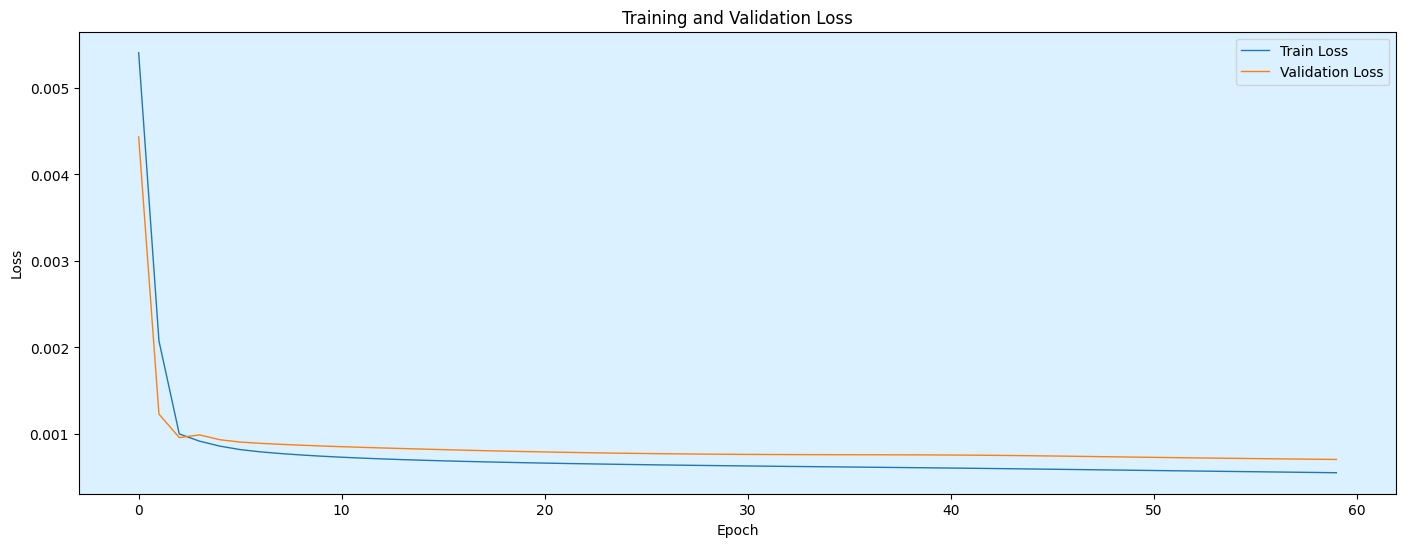

In [276]:
# Evolución del loss en train y validación
plt.figure(figsize=(17, 6))
plt.plot(lstm.loss_during_training, label='Train Loss')
plt.plot(lstm.valid_loss_during_training, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

Como se puede observar en la gráfica de evolución de loss, no existe sobreentrenamiento (el error de validación decrece y se mantiene cercano al de entrenamiento). Además, la curva se horizontaliza en las últimas épocas de entrenamiento, por lo que se puede asegurar que el modelo converge.

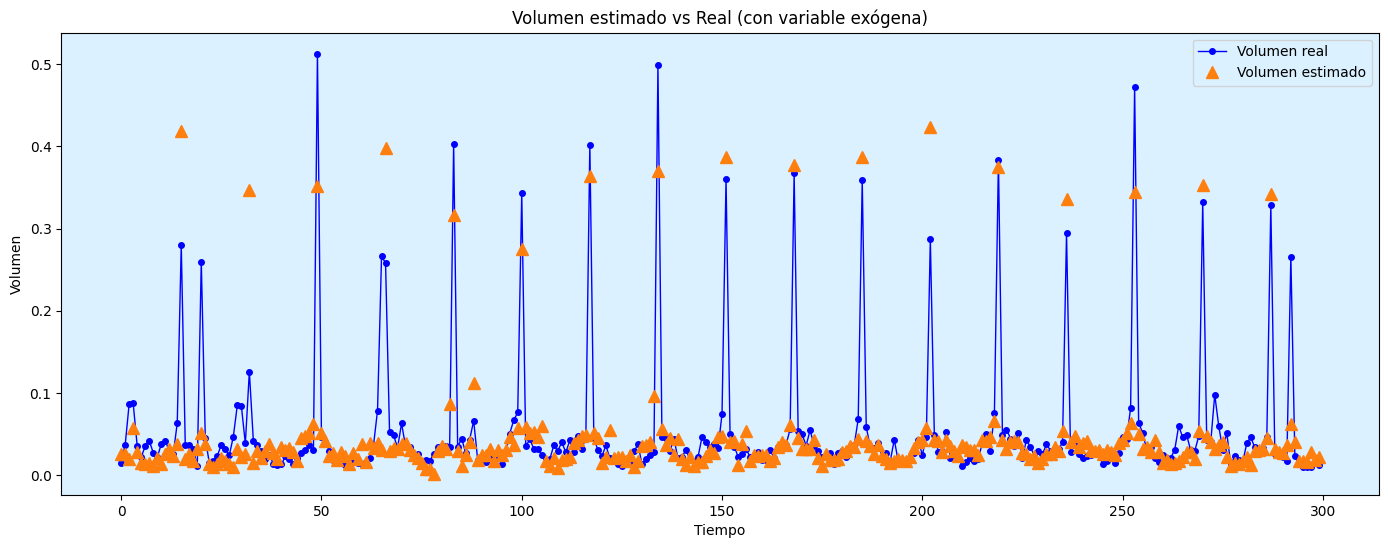

In [277]:
# Obtenemos predicciones en el conjunto de prueba
X_test_in = torch.Tensor(X_test_exog).view([X_test_exog.shape[0], 1, X_test_exog.shape[1]]).float()
predictions_test = lstm.forward(X_test_in)
predictions_test = predictions_test.detach().numpy().reshape([X_test_exog.shape[0], -1])

# Definir puntos de tiempo inicial y final para la representación (es configurable, para poder ver con mayor resolución y detalle los errores en una sección en concreto de todo el conjunto de test)

# Punto de tiempo inicial de la representación
t0 = 0

# Punto final
tf = 300

# Configuración del estilo del gráfico
plt.figure(figsize=(17, 6))

# Trazamos los valores reales y las predicciones
plt.plot(np.arange(t0, tf, 1), y_test_exog[t0:tf], 'b.-', label='Volumen real', markersize=8)
plt.errorbar(np.arange(t0, tf, 1), predictions_test[t0:tf], linestyle='None', marker='^', color='tab:orange', label='Volumen estimado', markersize=8, capsize=5)
plt.xlabel('Tiempo')
plt.ylabel('Volumen')
plt.title('Volumen estimado vs Real (con variable exógena)')
plt.legend(loc='best')

plt.show()

En este caso, para la LSTM con variable exógena, el MSE en el conjunto de test para este modelo es de 0.0009956246940419078.
El modelo es capaz de predecir de forma precisa los intervalos de bajo volumen. Como se ve, el añadir esta variable exógena no supone un gran impacto en las predicciones en test.
En general, el modelo parece que estima de forma bastante precisa la tendencia de crecimiento y decrecimiento de los grandes picos de volumen.

### Regresión Lineal

### Sin variable exógena

In [278]:
# En este caso, únicamente se realiza el entrenamiento con el dataset sin variable exógena

lin_reg_model = LinearRegression()

# Entrenamos el modelo con los conjuntos de datos sin exógena
lin_reg_model.fit(X_train_volumen.reshape(-1, window_size), y_train_volumen)

# Realizamos predicciones sobre el conjunto de test
y_pred_test = lin_reg_model.predict(X_test_volumen.reshape(-1, window_size))

# Evaluamos los resultados del modelo
mse = mean_squared_error(y_test_volumen, y_pred_test)
print("Mean Squared Error (MSE) en el conjunto de prueba:", mse)

Mean Squared Error (MSE) en el conjunto de prueba: 0.0010626647121007586


[]

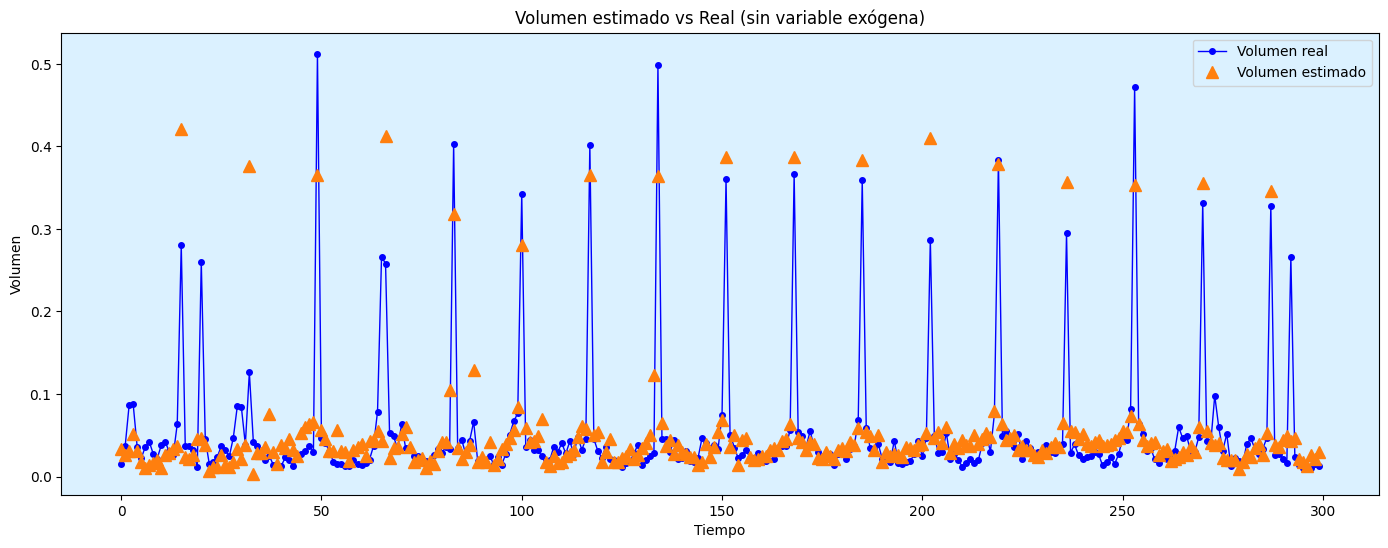

In [279]:
# Obtenemos predicciones en el conjunto de prueba
y_pred_test = lin_reg_model.predict(X_test_volumen.reshape(-1, window_size))

# Definir puntos de tiempo inicial y final para la representación (es configurable, para poder ver con mayor resolución y detalle los errores en una sección en concreto de todo el conjunto de test)

# Punto de tiempo inicial de la representación
t0 = 0

# Punto final
tf = 300

# Configuración del estilo del gráfico
plt.figure(figsize=(17, 6))

# Trazamos los valores reales y las predicciones
plt.plot(np.arange(t0, tf, 1), y_test_volumen[t0:tf], 'b.-', label='Volumen real', markersize=8)
plt.errorbar(np.arange(t0, tf, 1), y_pred_test[t0:tf], linestyle='None', marker='^', color='tab:orange', label='Volumen estimado', markersize=8, capsize=5)
plt.xlabel('Tiempo')
plt.ylabel('Volumen')
plt.title('Volumen estimado vs Real (sin variable exógena)')
plt.legend(loc='best')
plt.plot()

En este caso, para el modelo de Regresión Lineal, se obtiene un error en test de 0.00106266471210075869, estando extremadamente cerca de los anteriores modelos (más complejos) en cuanto a rendimiento. Este suceso se alinea con lo expuesto en clase sobre que, en el ámbito financiero, el modelo (o su complejidad) no suele ser determinante en el rendimiento que se consiga.

El modelo de regresión estima con exactitud los intervalos de bajo volumen negociado, y consigue describir la tendencia de los picos de alto volumen.

### Con variable exógena

In [280]:
# En este caso, únicamente se realiza el entrenamiento con el dataset sin variable exógena

lin_reg_model = LinearRegression()

# Entrenamos el modelo con los conjuntos de datos sin exógena
lin_reg_model.fit(X_train_exog.reshape(-1, window_size*2), y_train_exog)

# Realizamos predicciones sobre el conjunto de test
y_pred_test = lin_reg_model.predict(X_test_exog.reshape(-1, window_size*2))

# Evaluamos los resultados del modelo
mse = mean_squared_error(y_test_exog, y_pred_test)
print("Mean Squared Error (MSE) en el conjunto de prueba:", mse)

Mean Squared Error (MSE) en el conjunto de prueba: 0.0010395491380649961


[]

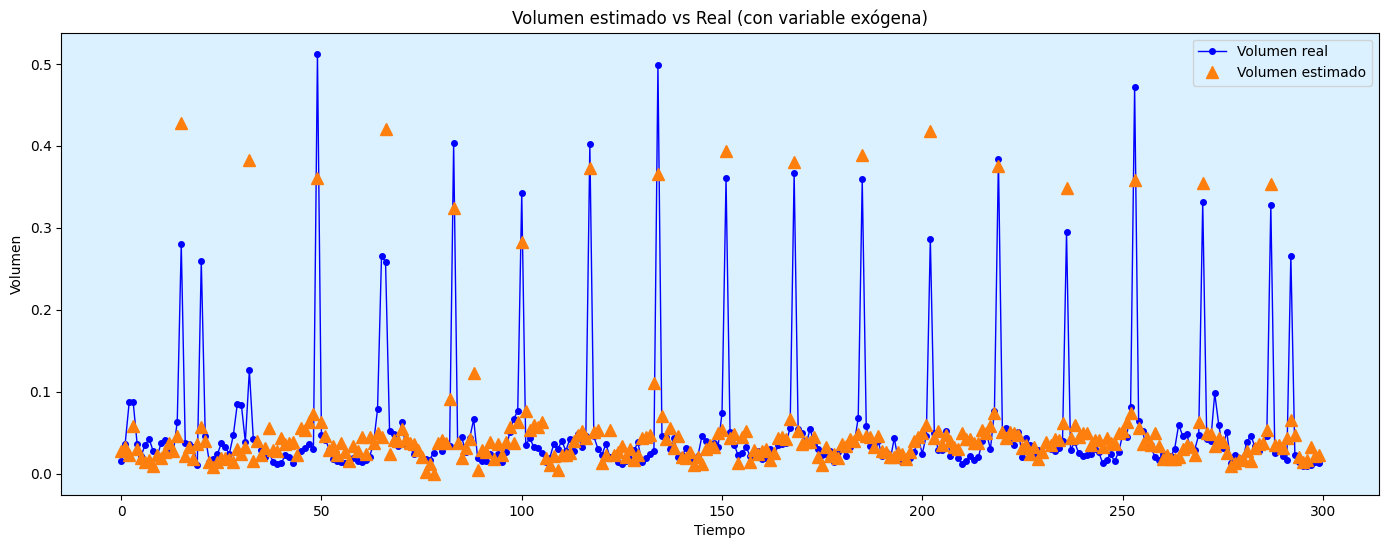

In [281]:
# Obtenemos predicciones en el conjunto de prueba
y_pred_test = lin_reg_model.predict(X_test_exog.reshape(-1, window_size*2))

# Definir puntos de tiempo inicial y final para la representación (es configurable, para poder ver con mayor resolución y detalle los errores en una sección en concreto de todo el conjunto de test)

# Punto de tiempo inicial de la representación
t0 = 0

# Punto final
tf = 300

# Configuración del estilo del gráfico
plt.figure(figsize=(17, 6))

# Trazamos los valores reales y las predicciones
plt.plot(np.arange(t0, tf, 1), y_test_exog[t0:tf], 'b.-', label='Volumen real', markersize=8)
plt.errorbar(np.arange(t0, tf, 1), y_pred_test[t0:tf], linestyle='None', marker='^', color='tab:orange', label='Volumen estimado', markersize=8, capsize=5)
plt.xlabel('Tiempo')
plt.ylabel('Volumen')
plt.title('Volumen estimado vs Real (con variable exógena)')
plt.legend(loc='best')
plt.plot()

En este caso, el error aplicando la variable exógena decrece levemente, obteniendo un MSE de 0.0010395491380649961. Siguiendo la línea de todos los modelos, los errores se concentran en los intervalos de grandes picos de volumen negociado. Sin embargo, la tendencia es captada bastante bien por el modelo.

### Mejor modelo

**Mejor modelo:** Teniendo en cuenta los errores de MSE en el conjunto de test mostrados anteriormente, parece que el modelo que devuelve los mejores resultado es MLP sin variabble exógena.
En general, parece que añadir la variable exógena propuesta no ha supuesto un gran impacto en el rendimiento de los modelos.

Por otro lado, cabe destacar el rendimiento del modelo de Regresión Lineal, ya que alcanza resultados muy cercanos a los otros modelos y goza de la capacidad de ser más simple y explicable, lo que podría resultar beneficioso si se quisiera aplicar en un entorno real.

**IMPORTANTE:** Dado que el objetivo es predecir el porcentaje de volumen de todos los intervalos de media hora para un día completo, es necesario aplicar una función que permita realizar dieciocho predicciones (una para cada intervalo de media hora que conforma un día completo) de forma consecutiva, empleando la predicción del intervalo i-ésimo para el intervalo i+1.
Esta función se muestra a continuación, empleando de ejemplo una instancia del conjunto de prueba con variable exógena.

In [287]:
def predict_multiple_intervals(model, data, arch, num_intervals=18, exog=True):
    predictions = []
    # Realizamos la predicción para cada intervalo
    for _ in range(num_intervals):
      if arch == 'mlp':
          with torch.no_grad():
              # Realizamos la inferencia con el modelo
              output = model(data.view(data.shape[0], -1))

          # Añadimos la predicción a la lista de predicciones
          predictions.append(output.item())

          # Actualizamos los datos para la siguiente predicción (quitamos el primer intervalo y añadimos la predicción más reciente)
          data[:, :-1] = data[:, 1:].clone()
          data[:, -1] = output.view(-1)  # Aseguramos que la forma sea compatible con la estructura de datos

      elif arch == 'lstm':
        output = torch.Tensor(data).view([data.shape[0], 1, data.shape[1]]).float()
        # Realizamos la inferencia con el modelo
        output = model.forward(output)
        output = output.detach().numpy().reshape([data.shape[0], -1])
        # Añadimos la predicción a la lista de predicciones
        predictions.append(output.item())

        # Actualizamos los datos para la siguiente predicción (añadimos la predicción más reciente y quitamos el primer valor)
        data = np.roll(data, -1, axis=1)
        data[:, -1] = output.flatten()  # Aseguramos que la forma sea compatible con la estructura de datos

      else:
        if exog:
          output = model.predict(data.reshape(-1, window_size*2))
        else:
          output = model.predict(data.reshape(-1, window_size))
        predictions.append(output.item())

        # Actualizamos los datos para la siguiente predicción (añadimos la predicción más reciente y quitamos el primer valor)
        data = np.roll(data, -1, axis=1)
        data[:, -1] = output.flatten()  # Aseguramos que la forma sea compatible con la estructura de datos


    return predictions

day_test_example_exog = DataLoader(test_dataset_exog, batch_size=1, shuffle=False)

# Como ejemplo sólo queremos que imprima un día completo para un conjunto X dado, por lo que añadimos un booleano que controle que la función sólo se ejecute una vez
cond = False
for data, labels in day_test_example_exog:
  if not cond:
    data = data.float()
    print("Predicción del día completo: ")
    prediction = predict_multiple_intervals(multi_layer, data, 'mlp')
    print(prediction)
    print("Longitud de la predicción: ", len(prediction))
    print("Suma de volúmenes predichos :", sum(prediction))
    cond = True


Predicción del día completo: 
[0.023660704493522644, 0.025304671376943588, 0.027002811431884766, 0.03974771499633789, 0.026231197640299797, 0.02314211055636406, 0.020907267928123474, 0.013666749931871891, 0.018731646239757538, 0.038803137838840485, 0.03645428642630577, 0.05429619178175926, 0.025782719254493713, 0.029285935685038567, 0.07695284485816956, 0.15856869518756866, 0.06572168320417404, 0.03407362848520279]
Longitud de la predicción:  18
Suma de volúmenes predichos : 0.7383339973166585


Como se puede comprobar, por ejemplo, para el modelo que mejores resultados devolvía en el conjunto de prueba (MLP), los resultados no son ideales al hacer uso de esta aproximación iterativa. Las salidas del modelo no suman exactamente 1. Además, los otros modelos (LSTM y Linear Regression) ofrecen resultados mucho peores.

Debido a esto, se propuso otra implementación capaz de realizar la predicción de los 18 intervalos que comprenden un día en una sola pasada en lugar de predecir únicamente el siguiente intervalo. De este modo, los errores en la predicción no serán acumulativos y se espera que las predicciones estén más cerca de 1.
En este caso, esta aproximación únicamente se evaluará con el mejor modelo (MLP). A continuación se muestran las modificaciones realizadas y los resultados obtenidos:

In [289]:
# Modificamos la ventana a 5
window_size = 5

In [290]:
# Es necesario generar una nueva estructura de labels porque ahora estamos prediciendo 18 valores en vez de uno solo

def generate_dataset_one_pass(data, window_size, target_length, exog=None):
    X, y = [], []

    for i in range(len(data) - window_size - target_length + 1):
        # Se va formando el conjunto de train incorporando los valores de la serie
        sequence = data.iloc[i:i + window_size]["VOLUMEN_NORMALIZADO"].tolist()

        if exog is not None:
            # Si se ha incorporado una variable exógena, se intercala
            sequence += data.iloc[i:window_size+i][exog].tolist()

        X.append(sequence)
        # Añadir los siguientes target_length valores como etiqueta
        y.append(data.iloc[i + window_size:i + window_size + target_length]["VOLUMEN_NORMALIZADO"].tolist())

    return torch.tensor(X), torch.tensor(y)

In [291]:
class MLP_ONE_PASS(nn.Module):
    def __init__(self, dimx, num_labels, hidden_layers, dropout=None, batch_norm=False, target_length=18):
        super().__init__()

        self.num_hidden_layers = len(hidden_layers) + 1
        self.layers = [dimx] + hidden_layers + [num_labels * target_length]  # Se multiplica num_labels por target_length (numero de salidas que esperamos)

        self.outputs = nn.ModuleList()
        for i in range(0, self.num_hidden_layers):
            self.outputs.append(nn.Linear(self.layers[i], self.layers[i+1]))

        self.relu = nn.ReLU()

        self.batch_norm = batch_norm
        self.batch_norm_layers = nn.ModuleList()
        if self.batch_norm:
            for b in range(0, self.num_hidden_layers):
                self.batch_norm_layers.append(nn.BatchNorm1d(self.layers[b + 1]))

        self.dropouts = nn.ModuleList()
        if dropout is not None:
            for d in range(0, len(dropout)):
                self.dropouts.append(nn.Dropout(p=dropout[d]))

        self.sigmoid = nn.Sigmoid()

    def forward(self, x):

        start_dropout = None
        if len(self.dropouts) != 0:
            start_dropout = self.num_hidden_layers - 1 - len(self.dropouts)

        for l in range(0, self.num_hidden_layers - 1):
            x = self.outputs[l](x)
            if self.batch_norm:
                x = self.batch_norm_layers[l](x)
            x = self.relu(x)
            if start_dropout is not None and l >= start_dropout:
                x = self.dropouts[l - start_dropout](x)

        x = self.outputs[-1](x)
        # No aplicamos sigmoid ya que queremos múltiples valores
        return x

In [292]:
class MLP_extended_ONE_PASS(MLP_ONE_PASS):
    def __init__(self, hidden_layers, dimx=6000, num_labels=1, dropout=None, batch_norm=False, lr=0.001, n_epochs=20):

        super().__init__(dimx, num_labels, hidden_layers, dropout, batch_norm)
        self.lr = lr
        self.epochs = n_epochs
        self.optim = optim.Adam(self.parameters(), self.lr)

        # Usamos la función de pérdida Mean Squared Error (MSE)
        self.criterion = nn.MSELoss()

        # LOSS EVOLUTION
        self.loss_during_training = []
        self.valid_loss_during_training = []

    def train_valid_loop(self, trainloader, valloader):

        earlyStopping = EarlyStopping(patience=10)
        for e in range(int(self.epochs)):
            running_loss = 0.
            for data, labels in trainloader:
                data = data.float()  # Convertir los datos a tipo float
                labels = labels.float()  # Convertir las etiquetas a tipo float
                self.optim.zero_grad()
                out = self.forward(data.view(data.shape[0], -1))
                loss = self.criterion(out, labels)
                running_loss += loss.item()
                loss.backward()
                self.optim.step()

            self.loss_during_training.append(running_loss/len(trainloader))

            torch.save(self.state_dict(), f'model_weights_{e}.pth')

            with torch.no_grad():
                self.eval()
                val_run_loss = 0.
                for validdata, validlabels in valloader:
                    validout = self.forward(validdata.view(validdata.shape[0], -1))
                    validloss = self.criterion(validout, validlabels)
                    val_run_loss += validloss.item()

                self.valid_loss_during_training.append(val_run_loss/len(valloader))
                earlyStopping(self.valid_loss_during_training[-1])

            self.train()

            if e % 1 == 0:
                print("training loss after %d epochs: %f" %(e, self.loss_during_training[-1]))
                print("validation loss after %d epochs: %f\n" %(e, self.valid_loss_during_training[-1]))

            if earlyStopping.early_stop:
                self.load_state_dict(torch.load(f'model_weights_{e - 10}.pth'))
                print('Stopping training due to early stopping')
                break

    def calculate_mse(self, testloader):
        criterion = nn.MSELoss()
        total_loss = 0.0
        num_samples = 0

        self.eval()

        with torch.no_grad():
            for data, labels in testloader:
                data = data.float()
                labels = labels.float()

                # Realizamos la inferencia con el modelo
                output = self(data.view(data.shape[0], -1))

                # Calculamos la pérdida de MSE entre las predicciones y las etiquetas verdaderas
                loss = criterion(output, labels)

                # Acumulamos la pérdida total y el número total de muestras
                total_loss += loss.item() * data.size(0)
                num_samples += data.size(0)

        # Calculamos el MSE promedio dividiendo la pérdida total entre el número total de muestras
        mse = total_loss / num_samples
        return mse


### Sin variable exógena

In [293]:
# Sin variable exógena
X_volumen, y_volumen = generate_dataset_one_pass(df_volumen, window_size, 18)
# Se divide el conjunto en train y test (80% / 20%)
# Por supuesto, no se aplica shuffle ya que hay que mantener el orden secuencial (son series temporales)
X_train_volumen, X_test_volumen, y_train_volumen, y_test_volumen = train_test_split(X_volumen, y_volumen, test_size=0.2, shuffle=False)
# El conjunto de train se divide en train y val (al tomar un 25% del 80%, val acaba teniendo el mismo tamaño que test)
X_train_volumen, X_val_volumen, y_train_volumen, y_val_volumen = train_test_split(X_train_volumen, y_train_volumen, test_size=0.25, shuffle=False)

# A continuación se generan los datasets y loaders para poder alimentar a los modelos
train_dataset_volumen = TensorDataset(X_train_volumen, y_train_volumen)
train_loader_volumen = DataLoader(train_dataset_volumen, batch_size=64, shuffle=False)

val_dataset_volumen = TensorDataset(X_val_volumen, y_val_volumen)
val_loader_volumen = DataLoader(val_dataset_volumen, batch_size=64, shuffle=False)

test_dataset_volumen = TensorDataset(X_test_volumen, y_test_volumen)
test_loader_volumen = DataLoader(test_dataset_volumen, batch_size=64, shuffle=False)

In [294]:
# Definimos los parámetros que presentará el MLP
hidden_layers = [32,32,32]
epochs = 100
dropout = [0.25]
batch_norm = True
lr = 0.001

In [295]:
# Instanciamos el MLP, lo entrenamos y evaluamos su error (MSE) en el conjunto de test
# En este caso, sin variable exógena (por lo que utilizamos los datasets sin exógena: 'train_loader_volumen', etc...)
multi_layer = MLP_extended_ONE_PASS(hidden_layers, n_epochs=epochs, lr=lr, dropout = dropout, batch_norm = batch_norm, dimx=X_train_volumen.shape[1])
multi_layer.train_valid_loop(train_loader_volumen, val_loader_volumen)
print("MSE en test:", multi_layer.calculate_mse(test_loader_volumen))

training loss after 0 epochs: 0.086217
validation loss after 0 epochs: 0.013905

training loss after 1 epochs: 0.029906
validation loss after 1 epochs: 0.009915

training loss after 2 epochs: 0.020085
validation loss after 2 epochs: 0.007746

training loss after 3 epochs: 0.015280
validation loss after 3 epochs: 0.007035

training loss after 4 epochs: 0.012271
validation loss after 4 epochs: 0.006633

training loss after 5 epochs: 0.010464
validation loss after 5 epochs: 0.006395

training loss after 6 epochs: 0.009144
validation loss after 6 epochs: 0.006217

training loss after 7 epochs: 0.008180
validation loss after 7 epochs: 0.006123

training loss after 8 epochs: 0.007661
validation loss after 8 epochs: 0.006062

training loss after 9 epochs: 0.007219
validation loss after 9 epochs: 0.005967

training loss after 10 epochs: 0.006839
validation loss after 10 epochs: 0.005930

training loss after 11 epochs: 0.006543
validation loss after 11 epochs: 0.005875

training loss after 12 e

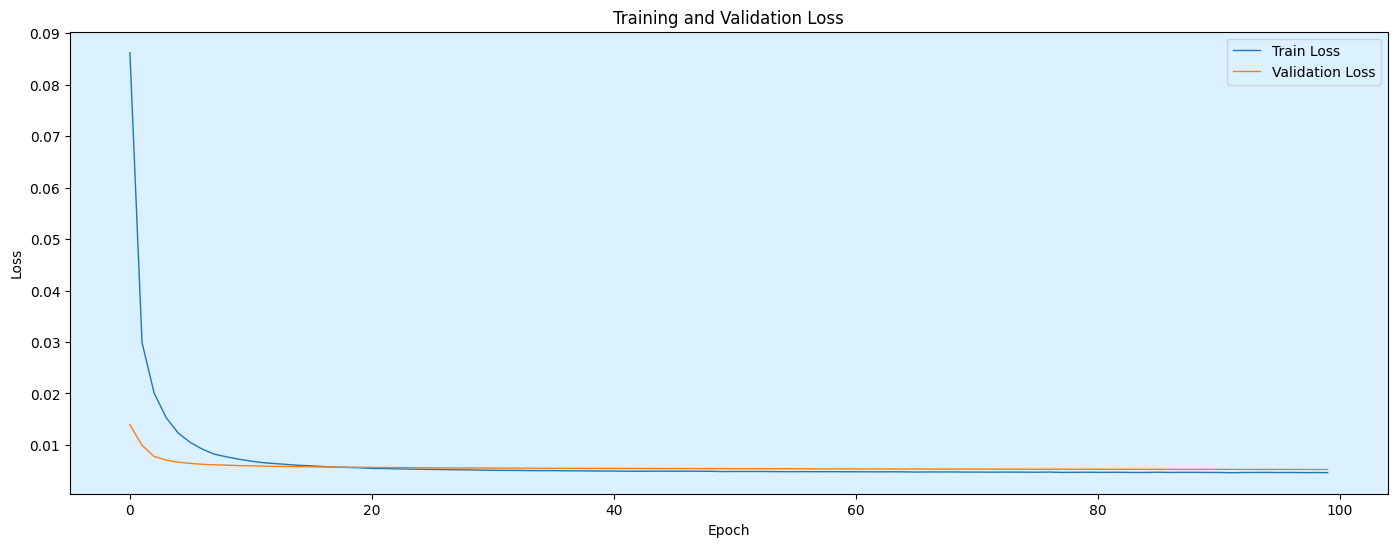

In [296]:
# Evolución del loss en train y validación
plt.figure(figsize=(17, 6))
plt.plot(multi_layer.loss_during_training, label='Train Loss')
plt.plot(multi_layer.valid_loss_during_training, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

Como se muestra en la imagen anterior, el modelo converge rápidamente alcanzando valores de error bastante bajos, generando una curva coherente.

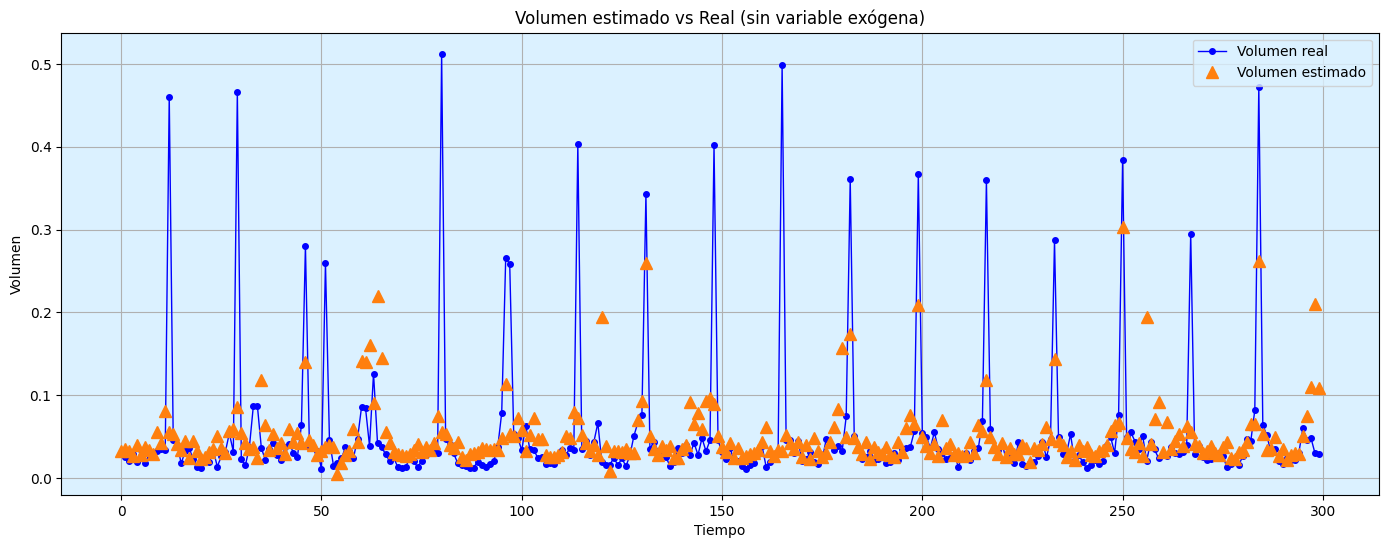

In [297]:
# IMPORTANTE: En este caso, al realizar predicciones sobre 18 valores diferentes (cada uno de los volumenes en los intervalos de 30 min), para facilitar la legibilidad de los gráficos y su entendimiento,
# únicamente se muestra la primera predicción de todo el intervalo y el primer valor en el volumen real. Si esto no se hiciera, complicaría mucho la interpretabilidad de los resultados.

# Obtenemos las predicciones del modelo en el conjunto de pruebas
predictions = []
targets = []

with torch.no_grad():
    for data, labels in test_loader_volumen:
        data = data.float()
        labels = labels.float()
        output = multi_layer(data.view(data.shape[0], -1))
        # Solo tomamos la primera predicción del intervalo
        predictions.extend(output[:, 0].numpy())
        # Solo tomamos el primer valor del volumen real
        targets.extend(labels[:, 0].numpy())

plt.figure(figsize=(17, 6))

# Definir puntos de tiempo inicial y final para la representación (es configurable, para poder ver con mayor resolución y detalle los errores en una sección en concreto de todo el conjunto de test)

# Punto de tiempo inicial de la representación
t0 = 0

# Punto final
tf = 300

# Trazamos los valores reales y las predicciones
plt.plot(np.arange(t0, tf, 1), targets[t0:tf], 'b.-', label='Volumen real', markersize=8)
plt.errorbar(np.arange(t0, tf, 1), predictions[t0:tf], linestyle='None', marker='^', color='tab:orange', label='Volumen estimado', markersize=8, capsize=5)
plt.xlabel('Tiempo')
plt.ylabel('Volumen')
plt.title('Volumen estimado vs Real (sin variable exógena)')
plt.legend(loc='best')
plt.grid(True)

plt.show()


Como se puede observar, el rendimiento en test no es ideal. Sí que consigue predecir de forma correcta, al igual que en casos anteriores, los intervalos de bajo volumen, pero presenta fallos de mayor magnitud en los grandes picos de volumen que la otra alternativa estudiada.
Sin embargo, esta alternativa no sufre del problema de los errores acumulados que podía sufrir el sistema iterativo.

### Con variable exógena

In [298]:
# Con variable exógena (puedes introducir cualquiera de las que especifico en la siguiente línea)
exog = 'VOLUMEN_ACUMULADO_ANTERIOR' # Otras posibles variables exógenas: 'VWAP' 'DIFERENCIA_MEDIA', 'VOLUMEN_ACUMULADO_ANTERIOR'
X_exog, y_exog = generate_dataset_one_pass(df_volumen, window_size, 18)
# Se divide el conjunto en train y test (80% / 20%).
# Por supuesto, no se aplica shuffle ya que hay que mantener el orden secuencial (son series temporales)
X_train_exog, X_test_exog, y_train_exog, y_test_exog = train_test_split(X_exog, y_exog, test_size=0.2, shuffle=False)
# El conjunto de train se divide en train y val (al tomar un 25% del 80%, val acaba teniendo el mismo tamaño que test)
X_train_exog, X_val_exog, y_train_exog, y_val_exog = train_test_split(X_train_exog, y_train_exog, test_size=0.25, shuffle=False)

# A continuación se generan los datasets y loaders para poder alimentar a los modelos
train_dataset_exog = TensorDataset(X_train_exog, y_train_exog)
train_loader_exog = DataLoader(train_dataset_exog, batch_size=64, shuffle=False)

val_dataset_exog = TensorDataset(X_val_exog, y_val_exog)
val_loader_exog = DataLoader(val_dataset_exog, batch_size=64, shuffle=False)

test_dataset_exog = TensorDataset(X_test_exog, y_test_exog)
test_loader_exog = DataLoader(test_dataset_exog, batch_size=64, shuffle=False)

In [299]:
# Definimos los parámetros que presentará el MLP
hidden_layers = [32,32,32]
epochs = 100
dropout = [0.25]
batch_norm = True
lr = 0.001

In [300]:
# Instanciamos el MLP, lo entrenamos y evaluamos su MSE en test
# En este caso, con variable exógena (por lo que utilizamos los datasets con exógena: 'train_loader_exog', etc...)
multi_layer = MLP_extended_ONE_PASS(hidden_layers, n_epochs=epochs, lr=lr, dropout = dropout, batch_norm = batch_norm, dimx=X_train_volumen.shape[1])
multi_layer.train_valid_loop(train_loader_volumen, val_loader_volumen)
print("MSE en test:", multi_layer.calculate_mse(test_loader_volumen))

training loss after 0 epochs: 0.098056
validation loss after 0 epochs: 0.016235

training loss after 1 epochs: 0.035441
validation loss after 1 epochs: 0.009596

training loss after 2 epochs: 0.023546
validation loss after 2 epochs: 0.007908

training loss after 3 epochs: 0.018479
validation loss after 3 epochs: 0.007165

training loss after 4 epochs: 0.014768
validation loss after 4 epochs: 0.006724

training loss after 5 epochs: 0.012409
validation loss after 5 epochs: 0.006577

training loss after 6 epochs: 0.011300
validation loss after 6 epochs: 0.006394

training loss after 7 epochs: 0.009802
validation loss after 7 epochs: 0.006244

training loss after 8 epochs: 0.008972
validation loss after 8 epochs: 0.006170

training loss after 9 epochs: 0.008190
validation loss after 9 epochs: 0.006083

training loss after 10 epochs: 0.007731
validation loss after 10 epochs: 0.006028

training loss after 11 epochs: 0.007276
validation loss after 11 epochs: 0.005933

training loss after 12 e

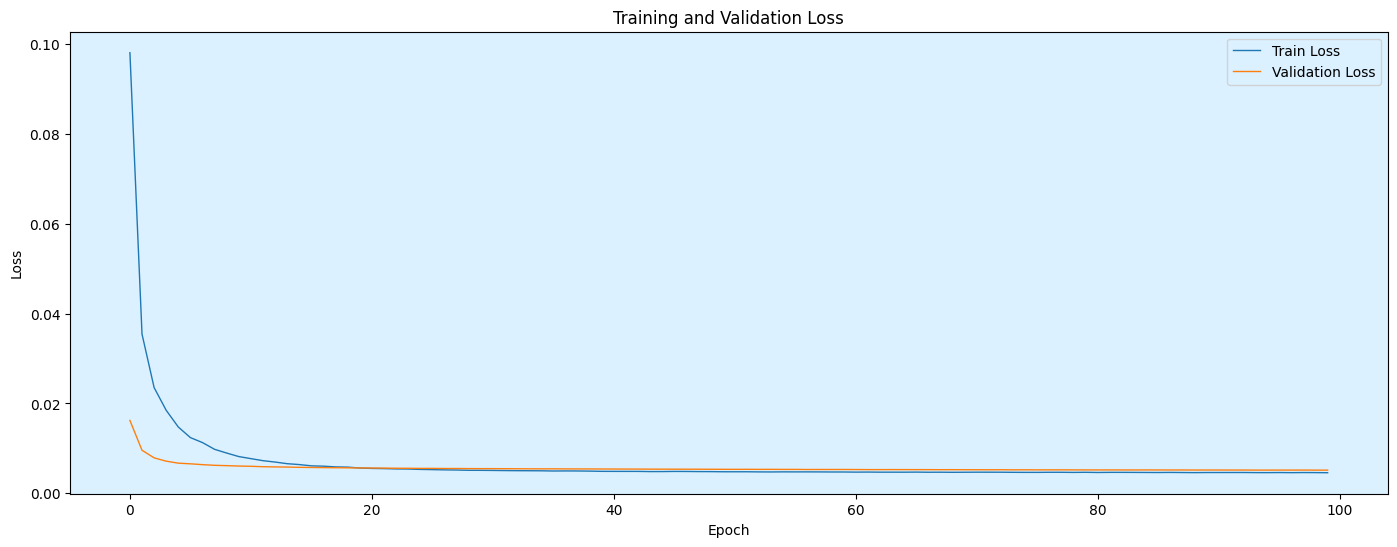

In [301]:
# Evolución del loss en train y validación
plt.figure(figsize=(17, 6))
plt.plot(multi_layer.loss_during_training, label='Train Loss')
plt.plot(multi_layer.valid_loss_during_training, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

De nuevo, las curvas de evolución del error son razonables, demostrando que el modelo converge.

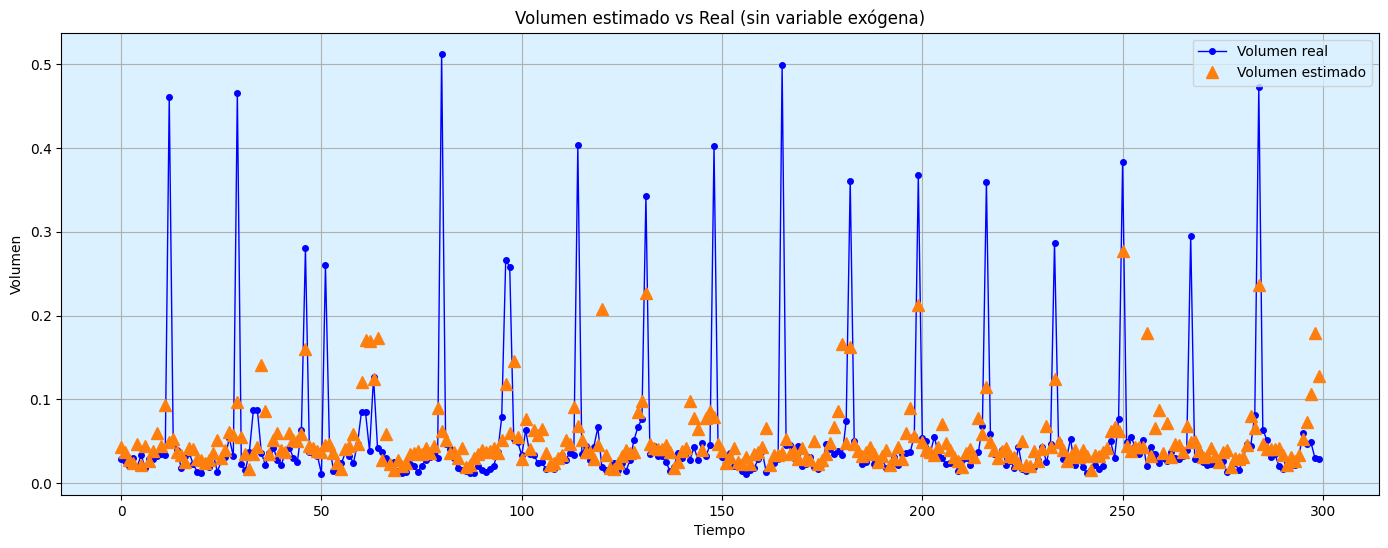

In [302]:
# IMPORTANTE: En este caso, al realizar predicciones sobre 18 valores diferentes (cada uno de los volumenes en los intervalos de 30 min), para facilitar la legibilidad de los gráficos y su entendimiento,
# únicamente se muestra la primera predicción de todo el intervalo y el primer valor en el volumen real. Si esto no se hiciera, complicaría mucho la interpretabilidad de los resultados.

# Obtenemos las predicciones del modelo en el conjunto de pruebas
predictions = []
targets = []

with torch.no_grad():
    for data, labels in test_loader_exog:
        data = data.float()
        labels = labels.float()
        output = multi_layer(data.view(data.shape[0], -1))
        # Solo tomamos la primera predicción del intervalo
        predictions.extend(output[:, 0].numpy())
        # Solo tomamos el primer valor del volumen real
        targets.extend(labels[:, 0].numpy())

plt.figure(figsize=(17, 6))

# Definir puntos de tiempo inicial y final para la representación (es configurable, para poder ver con mayor resolución y detalle los errores en una sección en concreto de todo el conjunto de test)

# Punto de tiempo inicial de la representación
t0 = 0

# Punto final
tf = 300

# Trazamos los valores reales y las predicciones
plt.plot(np.arange(t0, tf, 1), targets[t0:tf], 'b.-', label='Volumen real', markersize=8)
plt.errorbar(np.arange(t0, tf, 1), predictions[t0:tf], linestyle='None', marker='^', color='tab:orange', label='Volumen estimado', markersize=8, capsize=5)
plt.xlabel('Tiempo')
plt.ylabel('Volumen')
plt.title('Volumen estimado vs Real (sin variable exógena)')
plt.legend(loc='best')
plt.grid(True)

plt.show()


En este caso, al aplicar la variable exógena, el error en test es de 0.005148935343893851. Muy similar al error que devolvía sin emplearla. De nuevo, parece que la exógena no supone un gran impacto en el modelo.
Al igual que en casos anteriores, es posible identificar la gran precisión del mmodelo en intervalos de bajo volumen y los errores que comete en momentos donde el porcentaje de volumen negociado es alto.

# **Ejercicio 3:** Optimización de Carteras

In [303]:
# Hacemos uso de la clase de HPR que nos proporcionó Fernando
class HprAlgorithm:

    def __init__(self, cov, corr):
        self.cov = cov
        self.corr = corr
        self.dist = self.correlDist(self.corr)

    def allocate(self):
        # Construct a hierarchical portfolio
        link = sch.linkage(self.dist, 'single')
        sortIx = self.getQuasiDiag(link)
        sortIx = self.corr.index[sortIx].tolist()
        hrp = self.getRecBipart(sortIx)
        #hrp = hrp.sort_index()
        hrp = hrp.sort_values(ascending=False)
        return hrp

    @staticmethod
    def getQuasiDiag(link):
        # Sort clustered items by distance
        link = link.astype(int)
        sortIx = pd.Series([link[-1, 0], link[-1, 1]])
        numItems = link[-1, 3]  # number of original items
        while sortIx.max() >= numItems:
            sortIx.index = range(0, sortIx.shape[0] * 2, 2)  # make space
            df0 = sortIx[sortIx >= numItems]  # find clusters
            i = df0.index
            j = df0.values - numItems
            sortIx[i] = link[j, 0]  # item 1
            df0 = pd.Series(link[j, 1], index=i + 1)
            sortIx = sortIx._append(df0)  # item 2
            sortIx = sortIx.sort_index()  # re-sort
            sortIx.index = range(sortIx.shape[0])  # re-index
        return sortIx.tolist()

    def getRecBipart(self, sortIx):
        # Compute HRP alloc
        w = pd.Series(1, index=sortIx)
        cItems = [sortIx]  # initialize all items in one cluster
        while len(cItems) > 0:
            cItems = [
                i[j:k]
                for i in cItems
                for j, k in ((0, len(i) // 2), (len(i) // 2, len(i)))
                if len(i) > 1
            ]  # bi-section
            for i in range(0, len(cItems), 2):  # parse in pairs
                cItems0 = cItems[i]  # cluster 1
                cItems1 = cItems[i + 1]  # cluster 2
                cVar0 = self.getClusterVar(cItems0)
                cVar1 = self.getClusterVar(cItems1)
                alpha = 1 - cVar0 / (cVar0 + cVar1)
                w[cItems0] *= alpha  # weight 1
                w[cItems1] *= 1 - alpha  # weight 2
        return w

    def getClusterVar(self, cItems):
        # Compute variance per cluster
        cov_= self.cov.loc[cItems, cItems] # matrix slice
        w_ = self.getIVP(cov_).reshape(-1, 1)
        cVar = np.dot(np.dot(w_.T, cov_), w_)[0, 0]
        return cVar

    @staticmethod
    def correlDist(corr):
        # A distance matrix based on correlation, where 0<=d[i,j]<=1
        # This is a proper distance metric
        # distance matrix
        dist = ((1 - corr) / 2.)**.5
        return dist

    def sort_corr(self):
        link = sch.linkage(self.dist, 'single')
        sortIx = self.getQuasiDiag(link)
        sortIx = self.corr.index[sortIx].tolist()
        return self.corr.loc[sortIx, sortIx]

    @staticmethod
    def getIVP(cov):
        # Compute the inverse-variance portfolio
        ivp = 1. / np.diag(cov)
        ivp /= ivp.sum()
        return ivp

    def plot_dendrogram(self, method='single'):
        link = sch.linkage(self.dist, method)
        fig, ax = plt.subplots(figsize=(10, 7))
        _ = sch.dendrogram(link,
                           labels=self.corr.columns,
                           ax=ax,
                           orientation='right')


In [304]:
# Del mismo modo, se hace uso de las funciones de estrategias de asignación de pesos en carteras que nos proporcionó Fernando

def hrp_portfolio(cov, corr):
    hpr_algo = HprAlgorithm(cov, corr)
    hpr = hpr_algo.allocate()
    hpr.name = 'hpr'
    return hpr

def ivp_portfolio(cov):
    ivp = 1. / np.diag(cov)
    ivp /= ivp.sum()
    ivp = pd.Series(ivp, index=cov.index)
    ivp = ivp.sort_values(ascending=False)
    ivp.name = 'ivp'
    return ivp

def eq_w_portfolio(returns):
    eqw = pd.Series(index=returns.columns)
    n = len(returns.columns)
    eqw.loc[:] = 1/n
    eqw.name = 'eqw'
    return eqw


def getMVP(cov_pd):
    cov = cov_pd.T.values
    n = len(cov)
    N = 100
    mus = [
        10 ** (5.0 * t / N - 1.0)
        for t in range(N)
    ]
    # Convert to cvxopt matrices
    S = opt.matrix(cov)
    #pbar = opt.matrix(np.mean(returns, axis=1))
    pbar = opt.matrix(np.ones(cov.shape[0]))
    # Create constraint matrices
    G = -opt.matrix(np.eye(n))  # negative n x n identity matrix
    h = opt.matrix(0.0, (n, 1))
    A = opt.matrix(1.0, (1, n))
    b = opt.matrix(1.0)
    # Calculate efficient frontier weights using quadratic programming
    portfolios = [solvers.qp(mu * S, -pbar, G, h, A, b)['x']
                  for mu in mus]
    ## CALCULATE RISKS AND RETURNS FOR FRONTIER
    returns = [blas.dot(pbar, x) for x in portfolios]
    risks = [np.sqrt(blas.dot(x, S * x)) for x in portfolios]
    ## CALCULATE THE 2ND DEGREE POLYNOMIAL OF THE FRONTIER CURVE
    m1 = np.polyfit(returns, risks, 2)
    x1 = np.sqrt(m1[2] / m1[0])
    # CALCULATE THE OPTIMAL PORTFOLIO
    wt = solvers.qp(opt.matrix(x1 * S), -pbar, G, h, A, b)['x']
    wt = list(wt)
    mvp = pd.Series(wt, index=cov_pd.index)
    mvp.name = 'mvp'
    return mvp

def get_port_serie(close_data, weights):
    future_data = close_data.loc[:, weights.index]
    future_data = future_data.fillna(method='ffill')
    returns_future_data = future_data.pct_change()
    returns_future_data = returns_future_data + 1
    returns_future_data.iloc[0,:] = weights
    port_data = returns_future_data.cumprod()
    portfolio_data = port_data.sum(axis=1)
    return portfolio_data

def porfolio_from_start_value(portfolio_data, start_value):
    portfolio_data_returns = portfolio_data.pct_change()
    portfolio_data_returns = portfolio_data_returns + 1
    portfolio_data_returns.iloc[0] = start_value
    portfolio_data_start = portfolio_data_returns.cumprod()
    return portfolio_data_start

In [305]:
# Para poder obtener los precios de cierre del IBEX, leemos el csv desde el directorio en el que se encuentre
directorio_ibex = '/content/drive/MyDrive/IA en Finanzas/IBEX.csv'
df_close = pd.read_csv(directorio_ibex, index_col=0)
# Definimos el número de días que se tendrán en cuenta (ventana de tiempo) para realizar la asignación de pesos
n_hist = 200

In [306]:
# Simplemente para acelerar la ejecución
warnings.filterwarnings("ignore")
opt.solvers.options['show_progress'] = False

In [307]:
# Inicializamos los portfolios de cada una de las estrategias como listas vacías
eq_w_port = []
ivp_w_port = []
hrp_w_port = []
mvp_w_port = []

# Se genera el historial de precios haciendo uso de la ventana de tiempo definida
# Si aún no se ha llegado a un día con suficientes días de histórico en función de lo definido (por ejemplo, si se define n_hist como 200 y no hay 200 días previos), la ventana se toma desde el primer valor que exista
# Por supuesto, los rebalanceos se realizan cada diez días, y esto se refleja en los steps y el valor inicial del bucle siguiente (sobre el que se realiza el recálculo)
for i in range (10, len(df_close),10):
  if i < n_hist:
    price_data = df_close.iloc[:i]
  else:
    price_data = df_close.iloc[i-n_hist:i]

  # Si no se pone este dropna, los valores no se corresponden con la realidad
  price_data = price_data.dropna(axis=1)

  close_data_future = df_close.iloc[i:i+10]
  returns = np.log(price_data).diff()
  returns = returns.dropna()

  # Se calculan los valores de media, covarianza y correlación que serán indispensables en algunas de las estrategias
  mu = returns.mean()
  cov = returns.cov()
  corr = returns.corr()

  # Para cada estrategia, se obtienen los datos de portfolio mediante las funciones anteriormente inicializadas
  eq_w = eq_w_portfolio(returns)
  eq_w_port.append(get_port_serie(close_data_future, eq_w))

  hrp_w = hrp_portfolio(cov, corr)
  hrp_w_port.append(get_port_serie(close_data_future, hrp_w))

  ivp_w = ivp_portfolio(cov)
  ivp_w_port.append(get_port_serie(close_data_future, ivp_w))

  mvp_w = getMVP(cov)
  mvp_w_port.append(get_port_serie(close_data_future, mvp_w))

In [308]:
# Como valor inicial se toma el 1 para poder comparar bien los resultados y estimar la rentabilidad de forma apropiada
df_eq = porfolio_from_start_value(eq_w_port[0], 1)
df_hrp = porfolio_from_start_value(hrp_w_port[0], 1)
df_ivp = porfolio_from_start_value(ivp_w_port[0], 1)
df_mvp = porfolio_from_start_value(mvp_w_port[0], 1)

# Se realizan los desplazamientos en las series para alinear los rebalanceos que se realizan cada diez días y que haya continuidad en los gráficos y poder analizar las rentabilidades de forma apropiada
for i in range(1, len(eq_w_port)):
  df_eq = df_eq.append(porfolio_from_start_value(eq_w_port[i], df_eq.iloc[-1]))
  df_hrp = df_hrp.append(porfolio_from_start_value(hrp_w_port[i], df_hrp.iloc[-1]))
  df_ivp = df_ivp.append(porfolio_from_start_value(ivp_w_port[i], df_ivp.iloc[-1]))
  df_mvp = df_mvp.append(porfolio_from_start_value(mvp_w_port[i], df_mvp.iloc[-1]))

In [309]:
# Se extraen las rentabilidades del IBEX para comparar las estrategias de rebalanceo de pesos e identificar cuáles lo superan en rentabilidad y cuáles no
df_ibex = pd.read_csv('/content/drive/MyDrive/IA en Finanzas/IBEX_div.csv', index_col=0)
# Calculamos las rentabilidades por medio del cambio porcentual
df_ibex_comp = df_ibex.pct_change()
# Agregamos 1 a cada valor de la serie y ajustamos el primer valor a 1 para poder comparar con las estrategias
df_ibex_comp = df_ibex_comp + 1
df_ibex_comp.iloc[0, 0] = 1
# Obtenemos los precios acumulados mediante cumprod
df_ibex_comp = df_ibex_comp.cumprod()

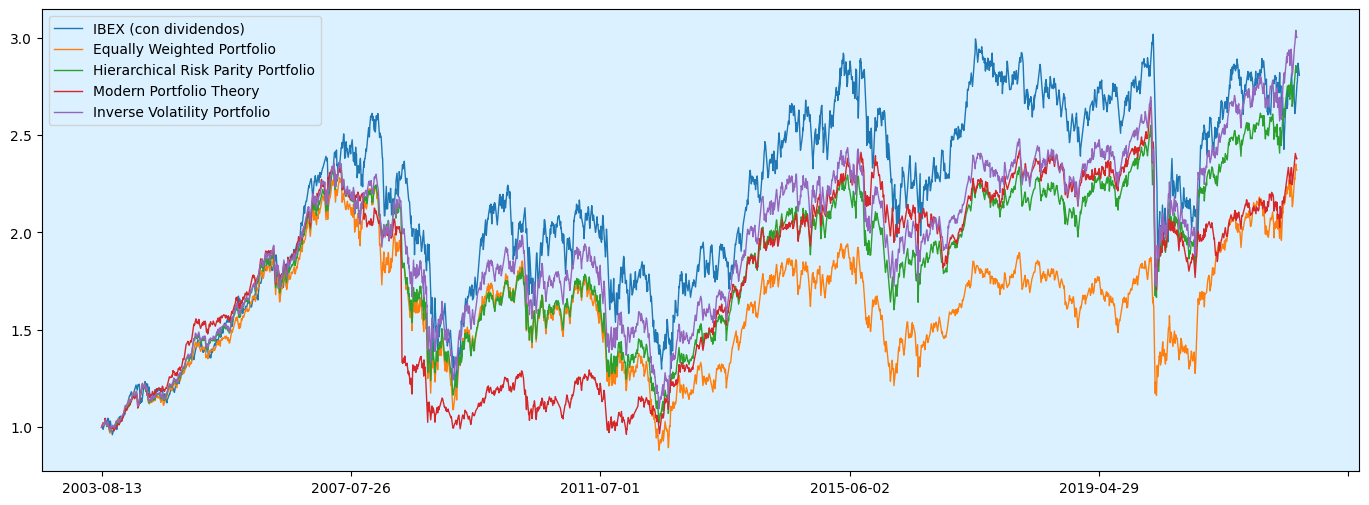

In [310]:
# Comparamos la rentabilidad del IBEX con el resto de estrategias
fig, ax = plt.subplots(figsize=(17,6))

df_ibex_comp['ibex_div'].plot(ax=ax, label = "IBEX (con dividendos)")
df_eq.plot(ax=ax, label = 'Equally Weighted Portfolio')
df_hrp.plot(ax=ax, label = 'Hierarchical Risk Parity Portfolio')
df_mvp.plot(ax=ax, label = 'Modern Portfolio Theory')
df_ivp.plot(ax=ax, label = 'Inverse Volatility Portfolio')

plt.legend(loc="best")
plt.show()

En primer lugar, es necesario mencionar que se ha realizado un **previo ajuste sobre el tamaño de ventana** que se emplea para el rebalanceo de pesos. Se evaluó la rentabilidad de las estrategias con ventanas de 50, 100, 150 y 200 días. Observando los resultados, se obesrvó que los mejores resultados se obtenían con una ventana de 200 días. De este modo, el gráfico que se evaluará y que se muestra es haciendo uso de esta ventana.

Como se puede observar en el gráfico anterior, el IBEX con dividendos ofrece una rentabilidad relativamente superior a la mayoría de estrategias, siendo consistentemente más rentable que por ejemplo, Hierarchichal Risk Parity, Equally Weighted o Modern Portfolio Theory.

Es fácil detecctar que, en los descensos de rentabilidad, **Modern Portfolio Theory** es una estrategia que se resiente más que el resto (siendo inferior a todas las demás cuando hay crisis). Sin embargo, en momentos de bonanza (como por ejemplo, desde 2011-07-01 hasta 2015-06-02), consigue ofrecer rentabilidades superiores a la mayoría de estrategias. De este modo, parece que para este caso en concreto, la estrategia de la frontera eficiente de Markovich no parece ideal.

En cuanto a **Equally Weighted Portfolio**, se puede observar que ofrece una rentabilidad bastante baja en comparación al resto. Al minimizar riesgos e intentar diversificar el capital de forma uniforme entre todas las empresas, esta estrategia se ve menos beneficiada que el resto en época de bonanza, y, en momentos donde la rentabilidad general decrece, tampoco consigue equipararse al resto de estrategias. En general, parece que esta estrategia tampoco es ideal.

Sobre **Hierarchichal Risk Parity Portfolio**, los resultados ya sí que están bastante cerca del IBEX. En este caso, parece que diversificar entre clusters de empresas similares en vez de repartir el capital entre todas las empresas como hacía Equally Weighted es una mejor estrategia.

Por último, para la ventana especificada, **Inverse Volatility Portfolio** consigue incluso superar al índice si se sigue la estrategia hasta el final (aunque es consistentemente inferior en rentabilidad hasta ese momento). Esta estrategia supera al resto durante todo el intervalo temporal evaludado. Teniendo en cuenta que se basa en la varianza de los productos, al asignar más peso a productos con menos volatilidad (menor varianza) y menos peso a los más volátiles (más varianza), se consigue que en los descensos generales de rentabilidad el efecto se minimice frente al resto de estrategias. Además, en este caso, en los intervalos de crecimiento consigue superar al resto de estrategias.